In [611]:
from termcolor import colored, cprint


# <p style="border:5px solid Navy;text-align:center;font-size:100%;">1.Импорт библиотек и подгрузка данных</p>
<div class="alert alert-primary" role="alert">

In [613]:


import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 
import squarify   
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_classif

import category_encoders as ce

# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42


from textblob import TextBlob, Blobber
from afinn import Afinn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Blobber
from termcolor import colored, cprint

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Поскольку одной из целей этого проекта является участие в соревновании на сайте **[kaggle](https://www.kaggle.com/competitions/sf-booking)**, скачаем данные, которые состоят из двух частей. Датасеты мы объеденим и, в дальнейшем, будем работать с одной таблицей.

In [614]:
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# обьединяем датасеты в один, для более удобной работы с одним датасетом, а не двумя.
data = pd.concat([df_train, df_test], ignore_index = True)

In [615]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# обьединяем датасеты в один, для более удобной работы с одной датасетом, а не двумя.
data = pd.concat([df_train, df_test], ignore_index = True)

Пропишем некоторые функции, которые будем использовать в проекте.

СЛУЖЕБНАЯ ФУНКЦИЯ ДЛЯ построения диаграммы древовидной карты

In [616]:
def chart_column_treemap(
    df,                  # dataframe
    col,                 # columns
    title,               # title
    title_fontsize=14,   # title font size
    size=[8, 4]):        # size of the chart

    grouped = df.groupby(col).size().sort_values(ascending=False).reset_index(name='Counts')
    labels = grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = grouped['Counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

    plt.figure(figsize=(size[0], size[1]), dpi= 80)
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

    plt.title(title, size=title_fontsize)
    plt.axis('off')
    plt.show();

СЛУЖЕБНАЯ ФУНКЦИЯ ДЛЯ УМЕНЬШЕНИЙ КАТЕГОРИЙ ПРИЗНАКА

In [617]:
def reduce_categories_number(df, col, n):
    '''
    Функция принимает датасет df, колонку col и n - количество наиболее частых категорий.
    Категории не входящие в n наиболее частых заменяются на 'Other'.
    Функция возвращает полученный датасет.
    '''
    popular_values = df[col].value_counts().nlargest(n).index
    df[col] = df[col].apply(lambda x: x if x in popular_values else 'Other')
    return df

СЛУЖЕБНАЯ ФУНКЦИЯ ДЛЯ ПОСТРОЕНИЯ ДИАГРАММЫ средней оценки от столбца

In [618]:
def chart_score_vs_column(
    df,                  # dataframe
    col,                 # columns
    title,               # title
    xlabel,              # X axis label
    ylabel,              # Y axis label

    size=[10, 5],        # size of the chart
    ylim=[5, 7],         # min/max of Y axis

                         # font sizes of:
    title_fontsize=16,   # title
    ticks_fontsize=12,   # ticks
    xlabel_fontsize=14,  # X axis label
    xticks_rotation=0,   # xticks rotation 
    ylabel_fontsize=14): # Y axis label
    
    grouped = df.groupby(col)['reviewer_score'].agg(['mean']).sort_values('mean')

    fig, ax = plt.subplots(figsize=(size[0], size[1]))

    plt.suptitle(title, size=title_fontsize)
    bar_types = sns.barplot(x=grouped.index, y=grouped['mean'])

    for p in bar_types.patches:
        bar_types.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.4, p.get_height()),
        ha='center', va='bottom', fontsize=int((title_fontsize+ticks_fontsize)/2))

    plt.ylim(ylim[0], ylim[1])
    plt.xlabel(xlabel, size=xlabel_fontsize)
    plt.ylabel(ylabel, size=ylabel_fontsize)
    plt.xticks(fontsize=ticks_fontsize)
    plt.xticks(rotation=xticks_rotation);

СЛУЖЕБНАЯ ФУНКЦИЯ для использования метода "МЕШКА СЛОВ" при анализе тэгов и отзывов

In [619]:
def add_bag_of_words(df, column, prefix, max_words=32):
    '''
    Input:
    - df;
    - column with text - should contain a string;
    - build a vocabulary that only consider the top max_words ordered by term frequency across the corpus.
      Otherwise, all features are used.

    Output:
    - df with added columns with 'bag of words';
    - list of words.
    '''
    # Convert a collection of text documents to a matrix of token counts.
    vectorizer = CountVectorizer(max_features=max_words) # stop_words='english'
    bow = vectorizer.fit_transform(df[column])

    count_array = bow.toarray()
    features = vectorizer.get_feature_names_out()
    
    prefixed_features = [prefix+element for element in features]
    
    bow_df = pd.DataFrame(data=count_array, columns=prefixed_features)
    
    return pd.concat([df, bow_df], ignore_index=False, axis=1), features

Функция для построения графика корреляций признаков

In [620]:

def chart_correlation_heatmap(df, 
                              columns, 
                              title, 
                              method='pearson', 
                              correlation_threshold=.7):
    """Построение корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    correlation_matrix = df[columns].corr(method=method).abs()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix[correlation_matrix.abs() > correlation_threshold], 
                annot=True,
                annot_kws={"fontsize":7}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='GnBu',
                fmt='.2f')
    ax_.set_title(title, fontsize=18)
    plt.show()

In [621]:
# добавим пикселей для графиков
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
# форматируем вывод данных pandas, чтобы убрать троеточие
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 50)

# <p style="border:5px solid Navy;text-align:center;font-size:100%;">1.2. Описание признаков</p>
<div class="alert alert-primary" role="alert">

### Признаки связанные с отелем:
#### - **hotel_name** - название отеля;
#### - **hotel_address** - адрес: улица, город, страна;
#### - **lat** - широта;
#### - **lng** - долгота;
#### - **average_score** - средний балл отеля, рассчитанный на основе последнего комментария за последний год;
#### - **total_number_of_reviews** - общее количество действительных отзывов об отеле;
#### - **additional_number_of_scoring** - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

<a id='1'></a>
<p style = "background-color : Navy; border-radius: 5px 5px; padding : 1px"><strong>

### Признаки связанные с рецензентом:
#### - **reviewer_nationality** - национальность рецензента;
#### - **total_number_of_reviews_reviewer_has_given** - количество отзывов, которые рецензенты дали в прошлом;
#### - **tags** - теги, которые рецензент дал отелю.

<a id='1'></a>
<p style = "background-color : Navy; border-radius: 5px 5px; padding : 1px"><strong>

### Признаки связанные с отзывами:
#### - **review_date** дата, когда рецензент разместил соответствующий отзыв;
#### - **days_since_review** продолжительность между датой проверки и датой очистки;
#### - **negative_review** отрицательный отзыв, который рецензент дал отелю;
#### - **review_total_negative_word_counts** общее количество слов в отрицательном отзыве;
#### - **positive_review** положительный отзыв, который рецензент дал отелю;
#### - **review_total_positive_word_counts** общее количество слов в положительным отзыве.

# <p style="border:5px solid Navy;text-align:center;font-size:100%;">2.0. Исследование данных и создание новых признаков</p>
<div class="alert alert-primary" role="alert">

Начнем с изучения данных.

In [622]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Проведем небольшое исследование зависимости целевого признака reviewer_score от числовых признаков.

In [623]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = data.dtypes
num_features = list(types[(types != 'object')].index)
del num_features[9:10] #удалим неинформативные признаки из списка
num_features

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng']

Для каждого числового признака построим гистограмму признаки и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии.

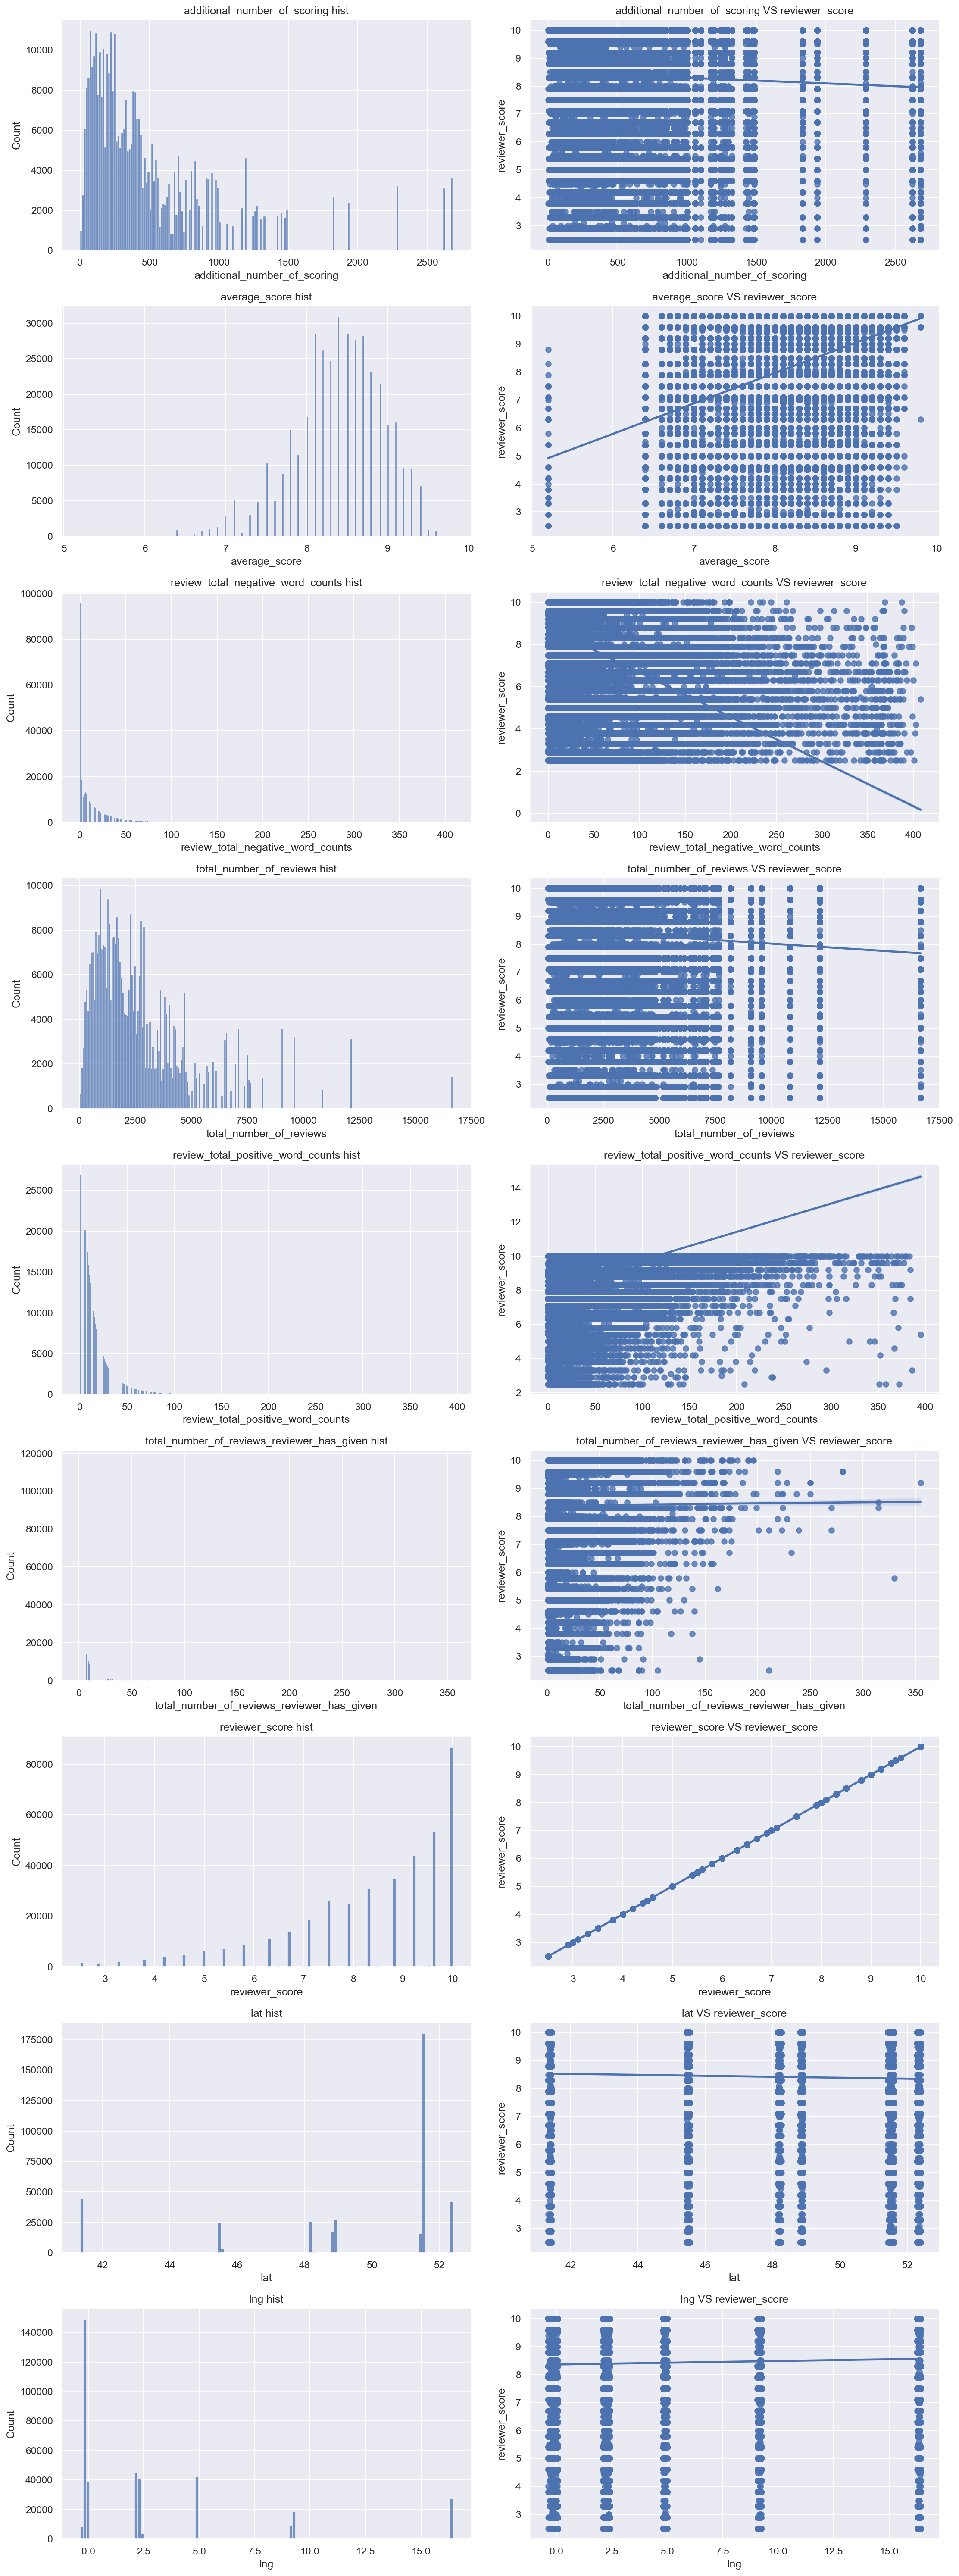

In [624]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # фигура + n х 2 координатных плоскостей
# Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data[data['sample']==1], x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data[data['sample']==1], x=feature, y='reviewer_score', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS reviewer_score'.format(feature))
plt.tight_layout() #выравнивание графиков

'review_total_negative_word_counts' и 'review_total_positive_word_counts' - есть сильная зависимость от целевого признака. Получается, что чем больше слов в негативной рецензии - тем ниже оценка (есть много негативных эмоций и соответственно слов), чем меньше - тем выше; для положительных отзывов - меньше слов - оценка ниже (нечего сказать положительного), много слов - высокая оценка (положительных эмоций много - можно и нахвалить множеством хороших слов)

Выведем при помощи служебной функции числовые признаки с сильной корреляцией

fig_1


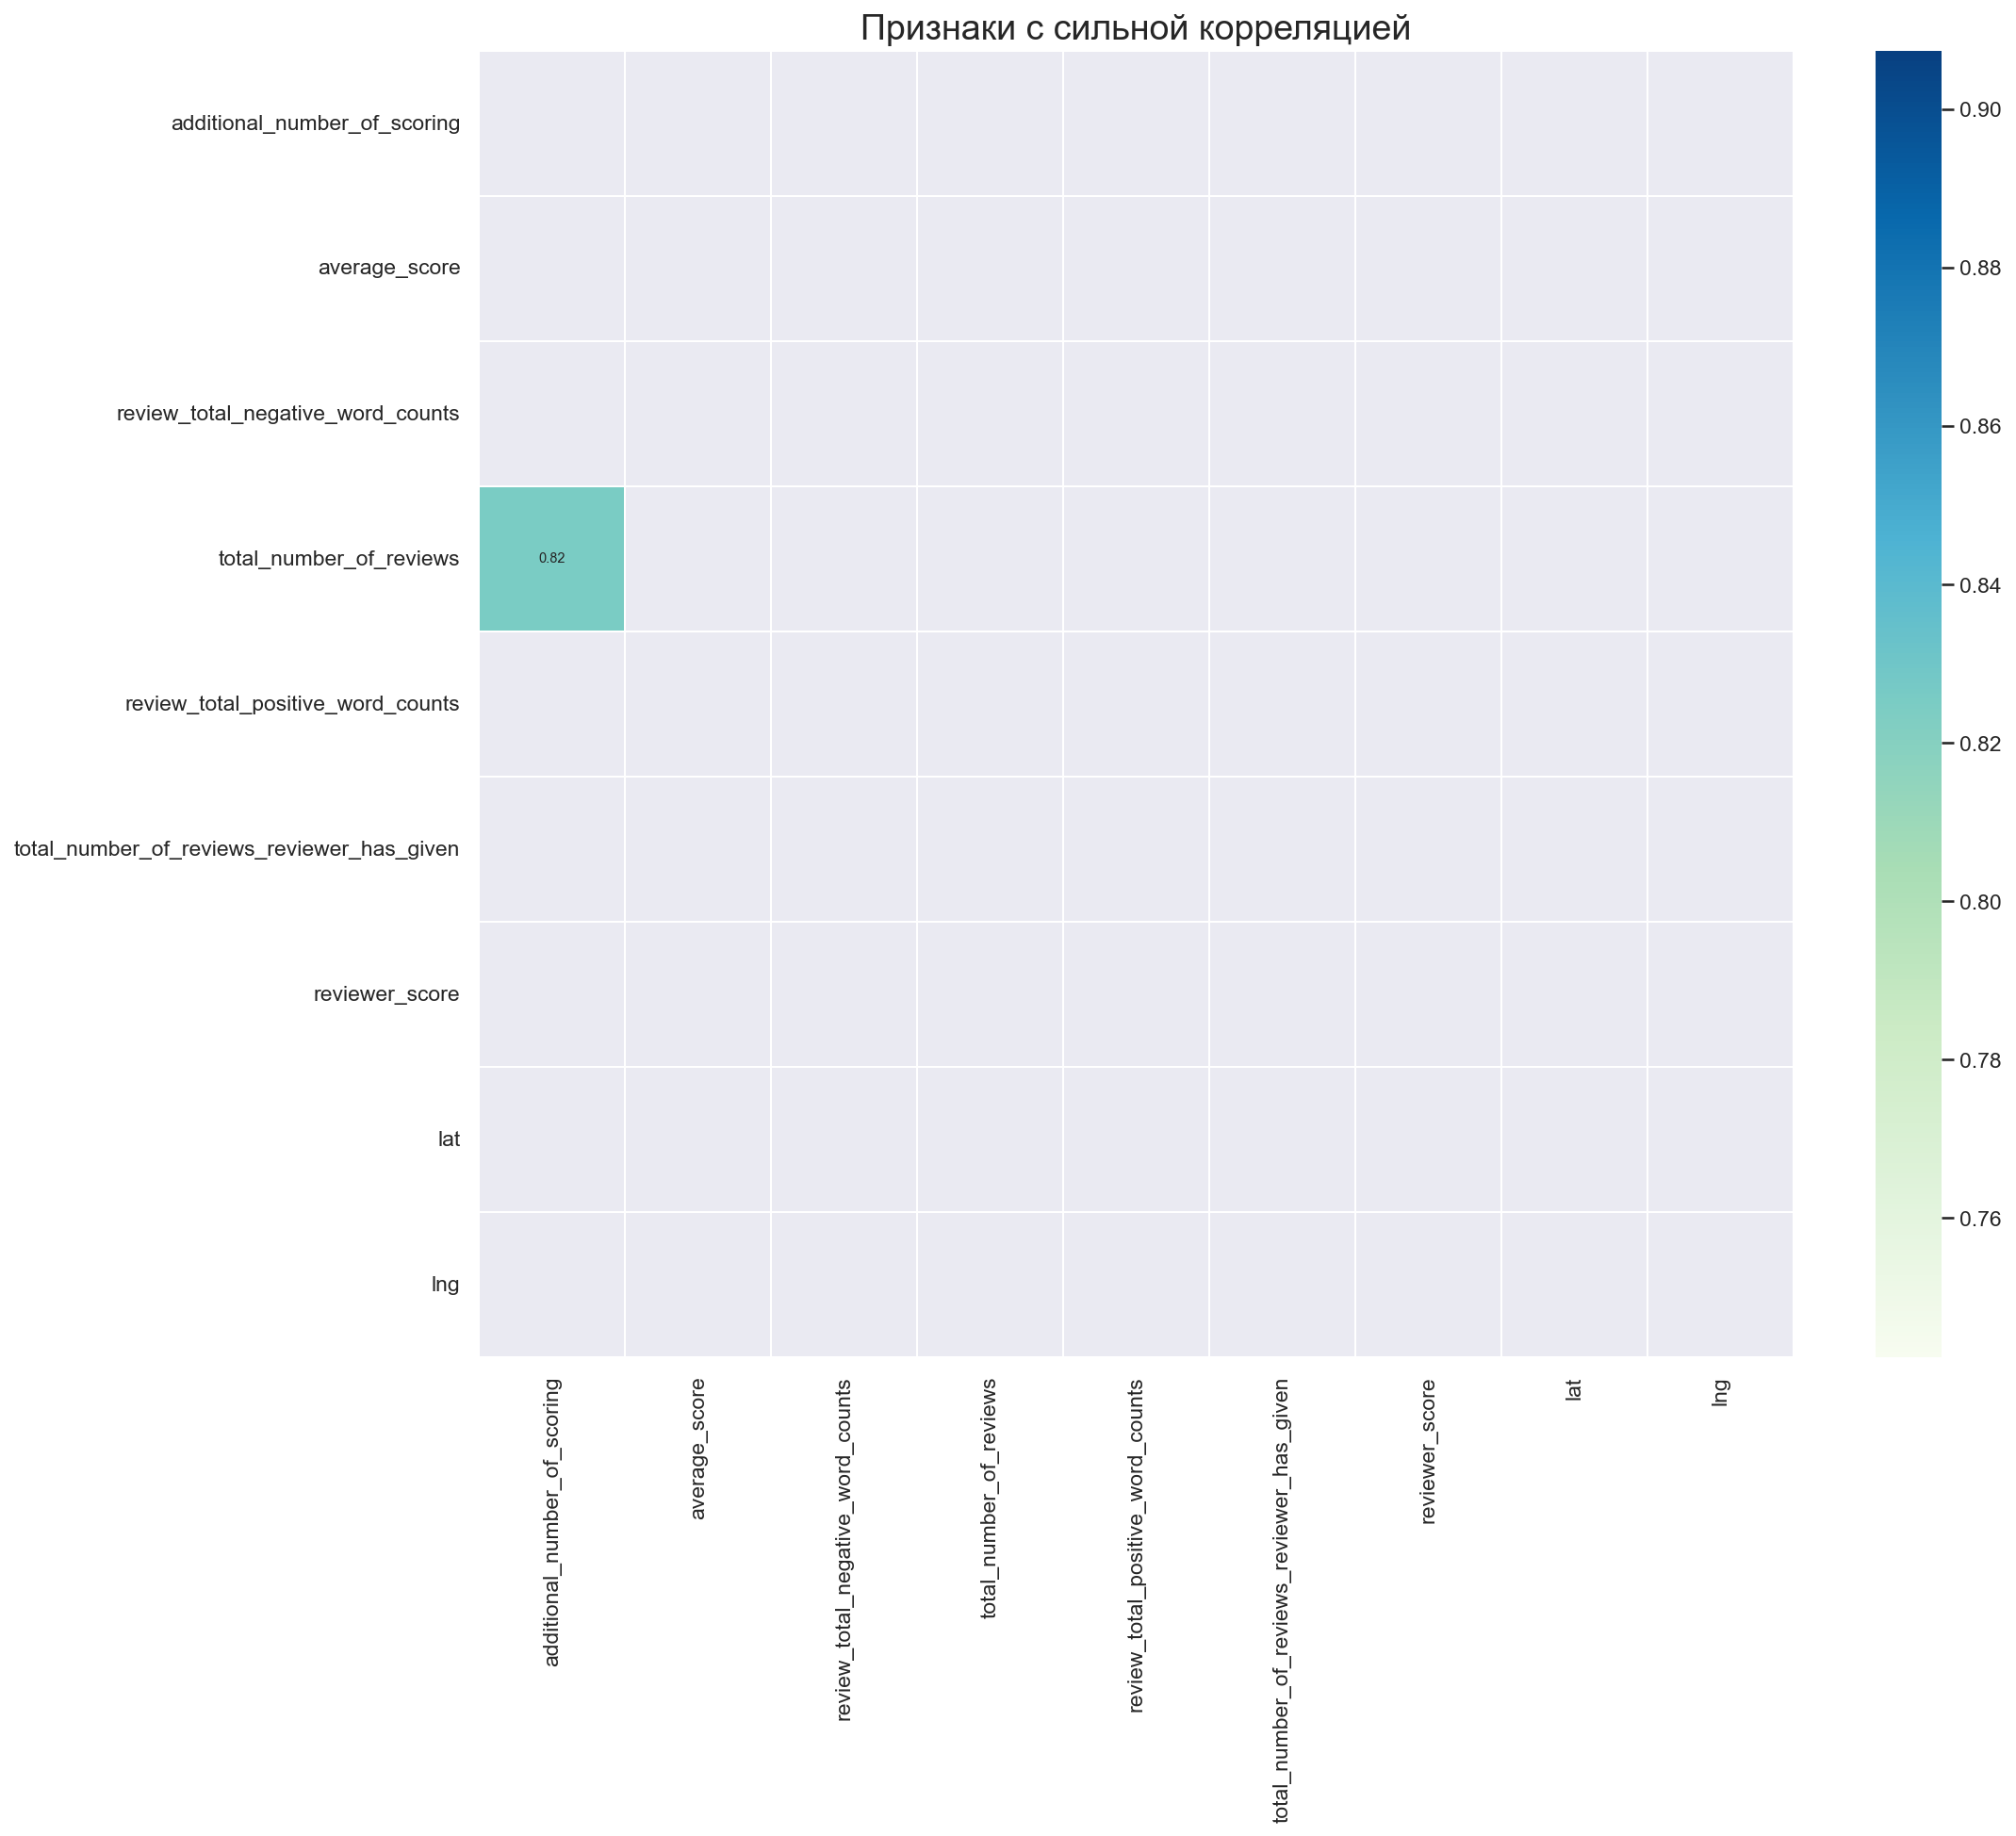

In [625]:
print(colored('fig_1', 'blue')) # название графика для github
#строим тепловую карту корреляций числовых признаков при помощи служебной функции
chart_correlation_heatmap(data, num_features, 'Признаки с сильной корреляцией')


Здесь видим сильную корреляцию между 'additional_number_of_scoring' и 'total_number_of_reviews'. Удалим один из признаков

In [626]:
data.drop(columns= ['additional_number_of_scoring'], inplace=True)

Выведем признаки с пропущенными данными

In [627]:
# узнаем сколько пропусков в данных в процентном исчислении
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
print(colored('Имеем {} признака с пропусками:'.format(len(cols_with_null)), 'blue'))
display(cols_with_null)


Имеем 2 признака с пропусками:


lat   0.634
lng   0.634
dtype: float64

fig_2
ЛОКАЛИЗАЦИЯ ПРОПУСКОВ В ДАННЫХ ПРИ ПОМОЩИ ТЕПЛОВОЙ КАРТЫ


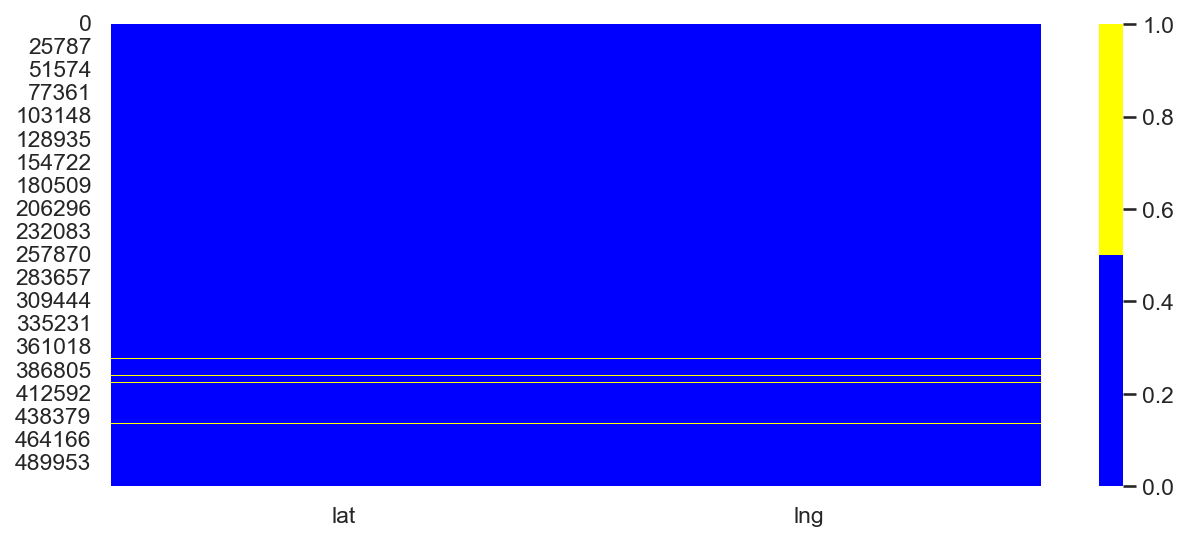

In [628]:
#построим тепловую карту пропусков с целью локализации пропусков в данных
print(colored('fig_2', 'blue'))
print(colored('ЛОКАЛИЗАЦИЯ ПРОПУСКОВ В ДАННЫХ ПРИ ПОМОЩИ ТЕПЛОВОЙ КАРТЫ', 'blue'))
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors)

)

Данные имеют менее одного процента пропусков в двух признаках. Пропущены координаты в некоторых строках. Пропуски в 'lat' идентичны 'lng'. Возможно обработаем эти пропуски позже.

В последствии оказалось, что признак координат заполненный нулями дает лучшие результаты метрики, чем отсутствие признака вообще, или реальные координаты в виде float64. Поэтому решил оставить признаки координат с нулями.

Здесь сохранил код для обработки недостающих координат

In [629]:
# создадим справочный фрейм для геокоординат отелей (пока с нулями)
# df_geo = data[data['lat'].isnull()].groupby('hotel_address').count()[['lat', 'lng']]
# print(colored('Заполним пропуски нулями:', 'blue'))
# df_geo


# напишем список с координатами по каждому из отелей в порядке расположения отелей в справочном фрейме 
# lst_geo = [[48.8399957, 2.3070823], 
          #  [48.8889127, 2.3309643], 
          #  [48.8753208, 2.3212033], 
          #  [41.391552, 2.1757053],
          #  [48.2208555, 16.3644228],
          #  [48.233592, 16.3434781],
          #  [48.2094054, 16.3512565],
          #  [48.2095525, 16.3492746],
          #  [48.1888183, 16.381591],
          #  [48.1868142, 16.418528],
          #  [41.3749946, 2.1102353],
          #  [48.219573, 16.2834034],
          #  [41.3832425, 2.1607609],
          #  [48.2458909, 16.3397395],
          #  [48.2135906, 16.3777195],
          #  [48.2168032, 16.357717],
          #  [48.220414, 16.3536299]]
          
          
# Заменим нули координатами
# for i in range (17):
    # df_geo.iloc[i] = lst_geo[i]
    
    
    
# df_geo
# дополним координатами  из справочного фрейма наш основной датафрейм
# data = data.set_index('hotel_address')
# data.update(df_geo)
# data = data.reset_index()

In [630]:
# Только два признака имеют пропуски. Пока заполним пропуски нулями
data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)

In [631]:
print(colored('Убедимся, что данные приведены к чистому виду:', 'blue'))

data.info()

Убедимся, что данные приведены к чистому виду:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_w

In [632]:
print(colored('Проверим значения на уникальность', 'blue'))

data.nunique(dropna=False)

Проверим значения на уникальность


hotel_address                                   1493
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    38
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
dtype: int64

Отметим небольшую разницу между количеством адресов, названий, долготы и широты отелей. Существенно эти детали не отразятся на нашем исследовании, но возможно вернемся к их обработке позже.

Посмотрим, есть ли дублирующие записи

In [633]:
print(colored('Выведем дубликаты в данных:', 'blue'))

data[data.duplicated ()]

Выведем дубликаты в данных:


hotel_address  \
21413                    9 Rue Sainte Beuve 6th arr 75006 Paris France   
53110               7 rue Casimir Delavigne 6th arr 75006 Paris France   
54461   40 Rue du Commandant Ren Mouchotte 14th arr 75014 Paris France   
56542               7 rue Casimir Delavigne 6th arr 75006 Paris France   
65789               7 rue Casimir Delavigne 6th arr 75006 Paris France   
...                                                                ...   
499212  40 Rue du Commandant Ren Mouchotte 14th arr 75014 Paris France   
506924  40 Rue du Commandant Ren Mouchotte 14th arr 75014 Paris France   
509781                     167 rue de Rome 17th arr 75017 Paris France   
512237  40 Rue du Commandant Ren Mouchotte 14th arr 75014 Paris France   
513653  40 Rue du Commandant Ren Mouchotte 14th arr 75014 Paris France   

       review_date  average_score                   hotel_name  \
21413    9/27/2015          8.900        Hotel Le Sainte Beuve   
53110    9/25/2016          9.000                  H tel Baume   
54461     8/2/2016          7.900  H tel Concorde Montparnasse   
56542     7/2/2017          9.000                  H tel Baume   
65789    8/11/2015          9.000                  H tel Baume   
...            ...            ...                          ...   
499212   5/23/2016          7.900  H tel Concorde Montparnasse   
506924    2/1/2016          7.900  H tel Concorde Montparnasse   
509781  12/12/2016          6.800                Villa Eugenie   
512237   9/22/2015          7.900  H tel Concorde Montparnasse   
513653   8/19/2015          7.900  H tel Concorde Montparnasse   

              reviewer_nationality  \
21413                  Costa Rica    
53110                     Lebanon    
54461                      Israel    
56542                     Romania    
65789              United Kingdom    
...                            ...   
499212   United States of America    
506924                      Malta    
509781                     Canada    
512237                    Germany    
513653                       Iraq    

                                                                                                         negative_review  \
21413                                                                                                        No Negative   
53110                                                                                                     nothing at all   
54461                                                                                      The room to far from elevator   
56542                                           Breakfast was a huge joke It was the worst poor i ever saw in a 4 hotel    
65789                                                                                                        No Negative   
...                                                                                                                  ...   
499212   Nothing I will stay at this hotel again on my next trip to Paris I have also recommended it to several friends    
506924                                                                                                    beautiful wiew   
509781                                                                                                      Listed above   
512237                                                                       Breakfast is pretty expensive however good    
513653                                                                            The lack of a refrigerator in the room   

        review_total_negative_word_counts  total_number_of_reviews  \
21413                                   0                      143   
53110                                   4                      253   
54461                                   7                     2515   
56542                                  19                      253   
65789                                   0                      253   
...      

Дублирующие записи есть, но они дублируются не по всем столбцам. Пока оставляем все как есть.

## <p style="border:5px solid Navy;text-align:center;font-size:100%;">3.1 Анализ информации об отелях</p>
<div class="alert alert-primary" role="alert">

Выделим город и страну для отелей из созданного нами датасета

In [634]:
# создадим новый признак страны
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1]\
                                            if x.split()[-1] != 'Kingdom'\
                                                    else ' '.join(x.split()[-2:]))
# создадим новый признак города 
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-2]\
                                         if x.split()[-1] != 'Kingdom'\
                                         else x.split()[-5])

Визуализируем при помощи служебных функций

fig_3


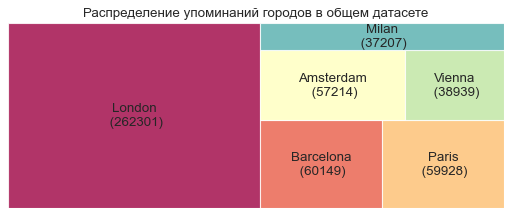

In [635]:
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-2]\
                                         if x.split()[-1] != 'Kingdom'\
                                         else x.split()[-5])

print(colored('fig_3', 'blue'))
chart_column_treemap(
    data,
    'hotel_city',
    'Распределение упоминаний городов в общем датасете',
    title_fontsize=12,
    size=[8, 3])

fig_4


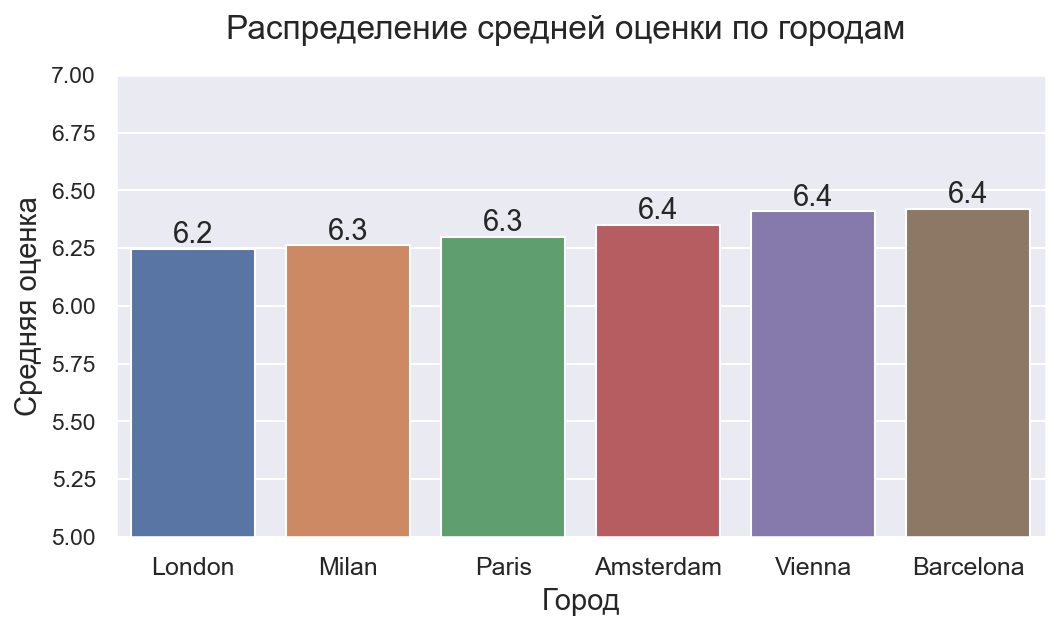

In [636]:
print(colored('fig_4', 'blue'))
chart_score_vs_column(data, 'hotel_city',
                      'Распределение средней оценки по городам',
                      'Город',
                      'Средняя оценка',
                      size=[8, 4], ylim=[5, 7])

In [637]:
# проверяем, что данные по стране и городу идентичны
print(colored('Всего шесть стран и шесть городов в этих странах:', 'blue'))
data[['hotel_country', 'hotel_city']].value_counts()

Всего шесть стран и шесть городов в этих странах:


hotel_country   hotel_city
United Kingdom  London        262301
Spain           Barcelona      60149
France          Paris          59928
Netherlands     Amsterdam      57214
Austria         Vienna         38939
Italy           Milan          37207
dtype: int64

Сложно сказать, что рейтинг отелей слишком зависит от городов. Разницу в несколько сотых долей пункта нельзя назвать существенной.

Очевидно, среди отелей из нашей базы данных, есть принадлежащие к большим сетям. Сгенерируем признак принадлежности отеля к какой-либо сети отелей, работающей в Европе.

In [638]:
print(colored('Исследуем названия отелей:', 'blue'))

data['hotel_name'].head(25)

Исследуем названия отелей:


0                            The May Fair Hotel
1               Mercure London Bloomsbury Hotel
2             Legend Saint Germain by Elegancia
3     Mercure Paris 19 Philharmonie La Villette
4                   Golden Tulip Amsterdam West
5               Novotel Milano Linate Aeroporto
6           Holiday Inn London Kensington Forum
7                        Mercure Josefshof Wien
8          The Gore Hotel Starhotels Collezione
9                Hilton London Kensington Hotel
10                  Golden Tulip Amsterdam West
11               Hotel Indigo London Kensington
12                               Number Sixteen
13          Holiday Inn London Kensington Forum
14                        Catalonia Park Putxet
15                             Ayre Hotel Caspe
16              Crowne Plaza London Kings Cross
17                Holiday Inn London Kensington
18                             New Linden Hotel
19                               Silken Ramblas
20                              Mondrian

In [639]:
# формируем список сетей отелей, действующих в Eвропе
hotels_chain_list = ['Hilton', 'Marriott', 'Holiday Inn', 'Hyatt', 'Sheraton',
                     'Premier Inn', 'Jurys Inns', 'Banyan', 'Seasons', 'Rixos', 
                     'Best Western', 'Crowne Plaza', 'Radisson', 'Ritz-Carlton',
                     'Best Western', 'Britannia Hotels ', 'Ibis', 'Kempinski', 
                     'Meridien', 'Ramada', 'Sofitel', 'Mercure', 'NH', 'Novotel',
                     'Macdonald', 'Ramada', 'Grange Hotels', 'Wetherspoon', 
                     'B&b', 'Campanile', 'Logis', 'Kyriad', 'Disney', 'Citotel',
                     'Collectionneurs', 'Brit', 'Mgallery', 'Fasthotel', 'Relais',
                     'Contact Hôtel', 'Starhotels', 'Gruppo Una', 'Blu Hotels', 
                     'Apogia', 'Iti', 'Leonardi', 'Charme E Relax', 'H10', 
                     'Meliá', 'Barceló', 'Eurostars', 'Senator', 'Catalonia', 
                     'Iberostar', 'Paradores', 'Ilunion', 'Tryp', 'Marriott',
                     'Exe', 'Silken', 'Vincci', 'Petit', 'Sercotel', 'Globales', 
                     'Austria Trend', 'Jufa', 'Privatecityhotels', 'Van Der Valk',
                     'Fletcher', 'Bastion', 'Golden Tulip']

# сформируем признак и обозначим отели принадлежащие к сети, как "1", в противном случае "0"
def get_hotel_cain(hotel_name):
    for name_cain in hotels_chain_list:
        if name_cain in hotel_name:
            return 1
    return 0
# добавим признак в таблицу
data['is_in_chain'] = data['hotel_name'].apply(get_hotel_cain)
print(colored('Принадлежность отелей к сети:', 'blue'))
data['is_in_chain'].value_counts(normalize=True)

Принадлежность отелей к сети:


0   0.678
1   0.322
Name: is_in_chain, dtype: float64

В наших данных 32% отелей относятся к какой-то из сетей отелей из нашего списка **hotels_chain_list**

# <p style="border:5px solid Navy;text-align:center;font-size:100%;">2.2. Анализ и создание признаков даты</p>
<div class="alert alert-primary" role="alert">

In [640]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month
data['day_of_week'] = data['review_date'].dt.weekday + 1 # Monday = 1, ..., Sunday = 7

data = data.drop('review_date', axis=1)

Построим визуализацию всех трех признаков даты

fig_5


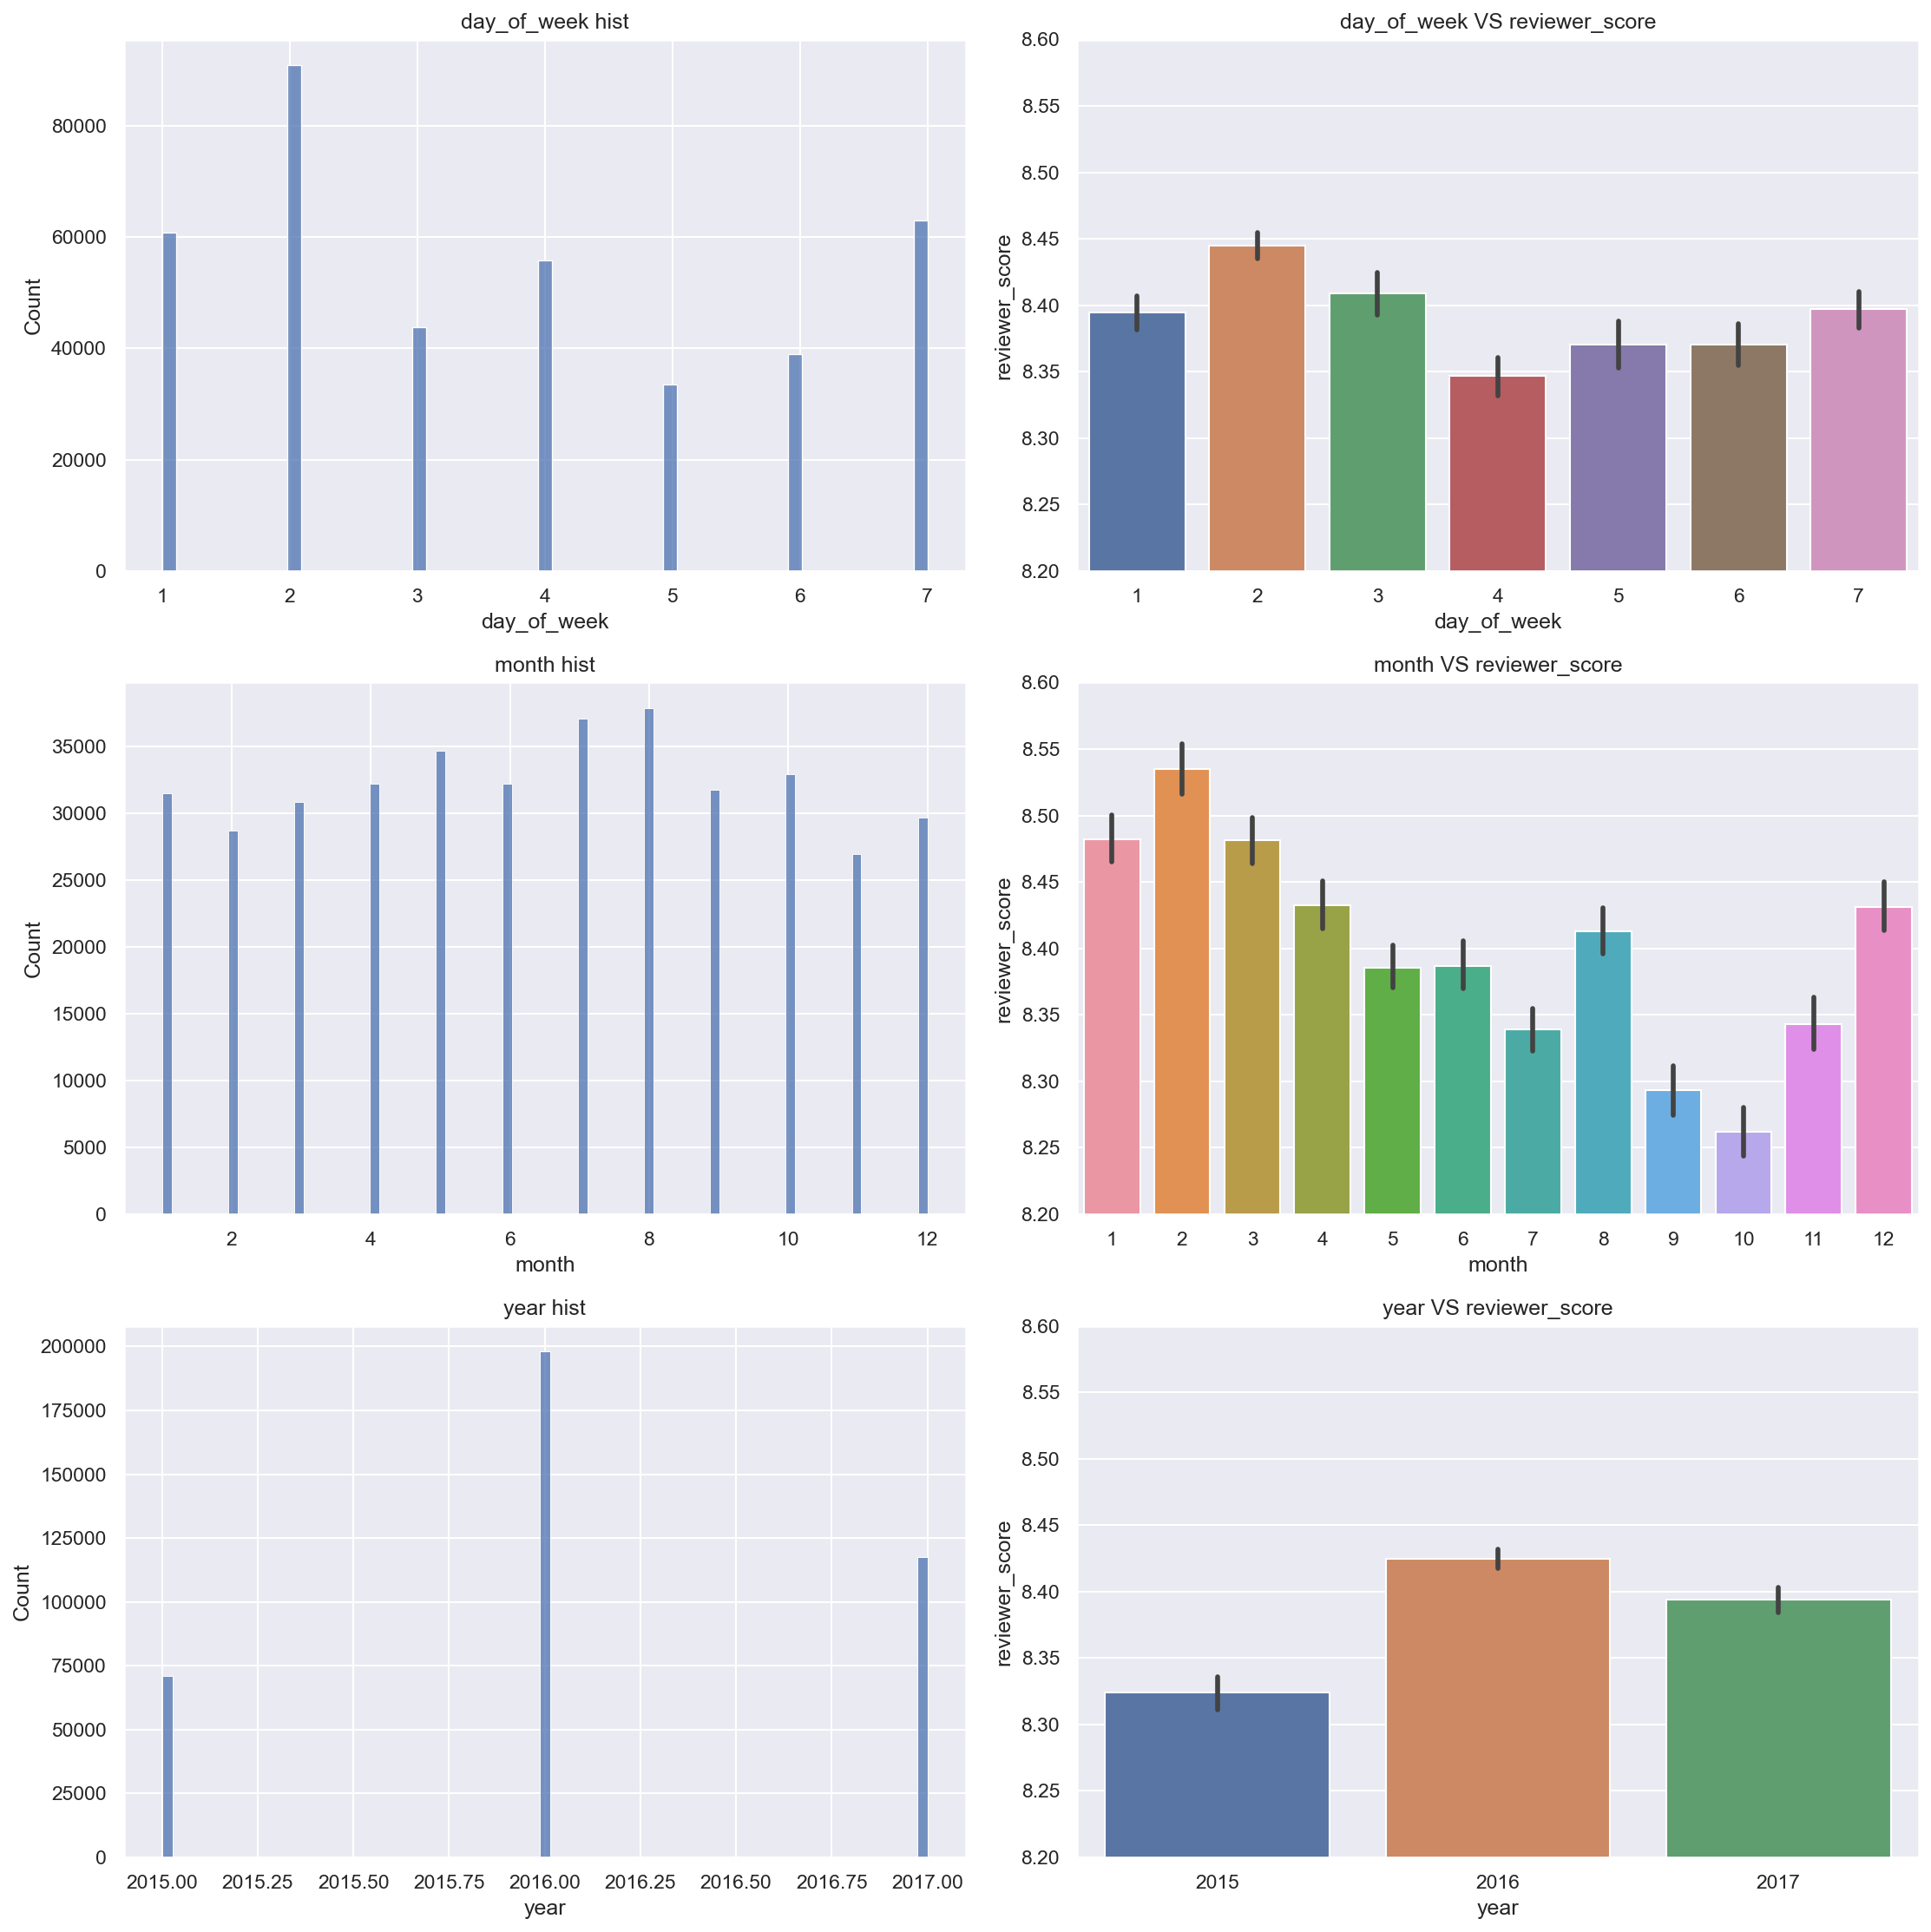

In [641]:
print(colored('fig_5', 'blue'))
new_features=['day_of_week','month','year'] #список признаков для визуализации

n = len(new_features) #количество признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 15)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(new_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data[data['sample']==1], x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Строим диаграмму рассеяния + линейную регрессию
    barplot = sns.barplot(data=data[data['sample']==1], x=feature, y='reviewer_score', ax=axes[i][1])
    barplot.set_ylim(8.2, 8.6)
    #Добавляем подпись графику
    barplot.set_title('{} VS reviewer_score'.format(feature));
plt.tight_layout() #выравнивание графиков

Мы можем видеть некоторую связь между датами рецензирования и количеством отзывов, например, большинство отзывов пишется по вторникам и меньше всего по пятницам. Данные охватывают период с 08.2015 по 08.2017 и большинство отзывов в нашем наборе данных относятся к 2016 году. Есть влияние на таргет, но не сильно значительное. Оставим новые признаки для дальнейшего анализа.

## <p style="border:5px solid Navy;text-align:center;font-size:100%;">2.3. Анализ и создание признаков рецензента</p>
<div class="alert alert-primary" role="alert">

Исследуем признак национальности рецензента

In [642]:
#посмотрим сколько имеется уникальных национальностей рецензентов
print(colored('Количество национальностей в наших данных:', 'blue'))
data['reviewer_nationality'].nunique()

Количество национальностей в наших данных:


227

Добавим колонку local_reviewer: '1' если национальность рецензента и страна отеля совпадают, в противном случае '0'.


In [643]:
#формируем список стран
countries_list = ['France', 'United Kingdom', 'Spain', 'Italy', 'Austria', 'Netherlands']

# сформируем признак и обозначим рецензента, который является гражданином данной страны, как "1", в противном случае "0"
def is_citizen(reviewer_nationality):
    for country in countries_list:
        if country in reviewer_nationality:
            return 1
    return 0

data['is_citizen'] = data['reviewer_nationality'].apply(is_citizen)
print(colored('1 это граждане путешествующие в своей стране:', 'blue'))
data['is_citizen'].value_counts()

1 это граждане путешествующие в своей стране:


1    274577
0    241161
Name: is_citizen, dtype: int64

In [644]:
# проверим новые признаки
data[['hotel_country', 'reviewer_nationality', 'is_citizen']].head(11)

hotel_country reviewer_nationality  is_citizen
0   United Kingdom      United Kingdom            1
1   United Kingdom      United Kingdom            1
2           France               China            0
3           France      United Kingdom            1
4      Netherlands              Poland            0
5            Italy              France            1
6   United Kingdom      United Kingdom            1
7          Austria      United Kingdom            1
8   United Kingdom      United Kingdom            1
9   United Kingdom      United Kingdom            1
10     Netherlands      United Kingdom            1

Уменьшим количество категорий до 11 наиболее частых и 'Other', используя служебную функцию.

In [645]:
data = reduce_categories_number(data, 'reviewer_nationality', 11)

fig_6


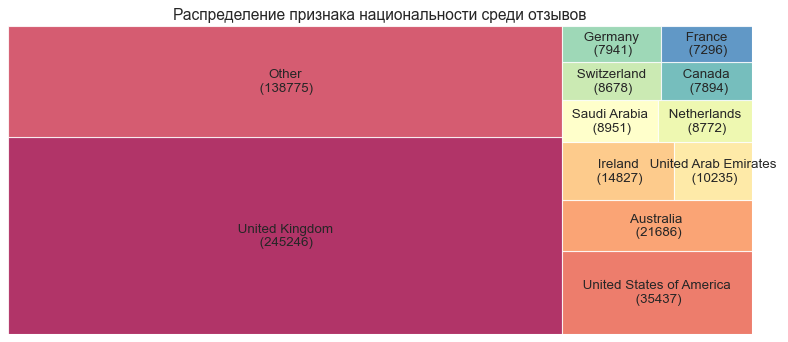

fig_7


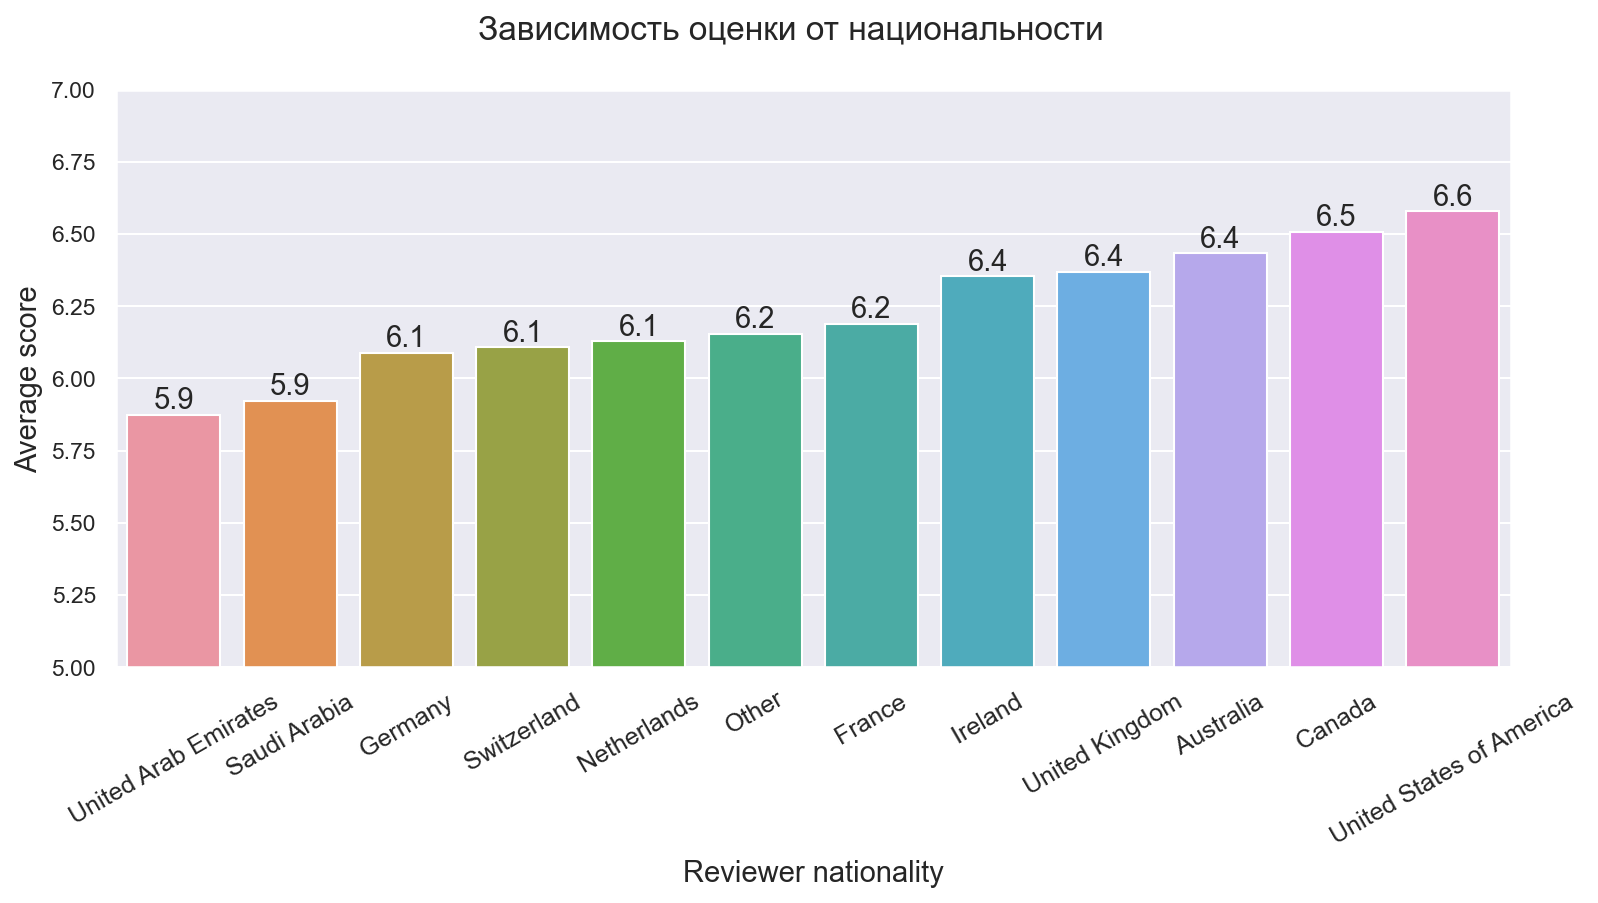

In [646]:
# Построим визуализацию
print(colored('fig_6', 'blue'))
chart_column_treemap(data, 'reviewer_nationality', 
                     'Распределение признака национальности среди отзывов', size=[12, 5])

print(colored('fig_7', 'blue'))
chart_score_vs_column(data, 'reviewer_nationality', 
                      'Зависимость оценки от национальности', 
                      'Reviewer nationality', 
                      'Average score', 
                      size=[12, 5], ylim=[5, 7], xticks_rotation=30)

Этот признак применим для построения модели. Так как ментальность людей очень разная, отличается и взгляд на комфорт и оценку реальности в зависимости от национальности. Не разбираясь кого и сколько, закодируем бинарно, так как уникальных значений 227.

Построим визуализацию количества отзывов для каждого рецензента

In [647]:
data['total_number_of_reviews_reviewer_has_given'].value_counts().head(10)

1     154640
2      67077
3      46845
4      35026
5      27629
6      22621
7      18614
8      16150
9      13545
10     11717
Name: total_number_of_reviews_reviewer_has_given, dtype: int64

fig_8


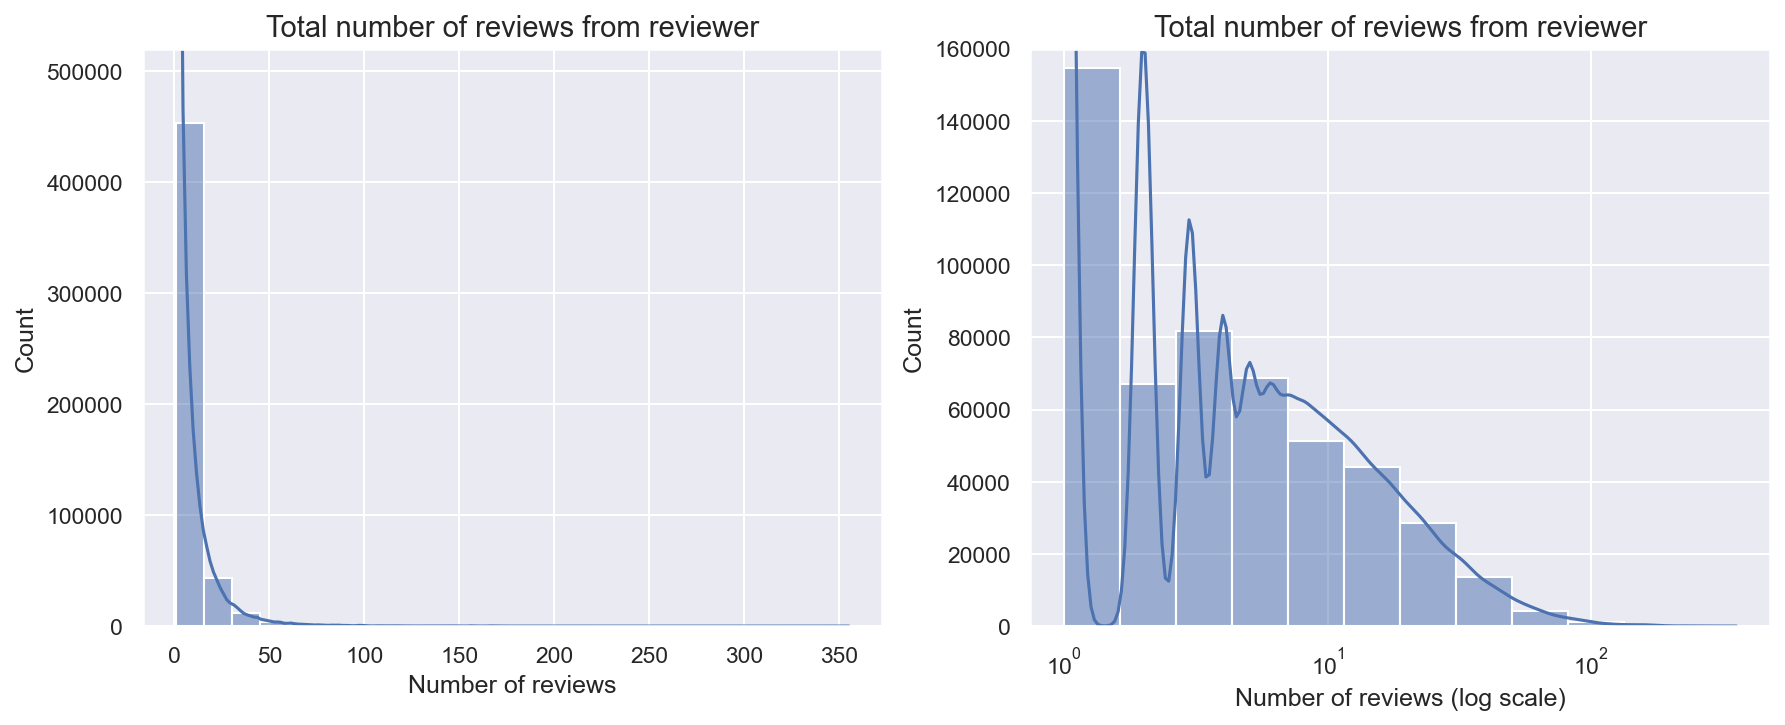

In [648]:
print(colored('fig_8', 'blue'))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
plt.subplots_adjust(hspace=.25)

histplot1 = sns.histplot(data=data, x='total_number_of_reviews_reviewer_has_given', 
                         bins=24, kde=True, log_scale=False, ax=axes[0])

histplot1.set_title('Total number of reviews from reviewer', fontsize=14)
histplot1.set_xlabel('Number of reviews', fontsize=12)
histplot1.set_ylabel('Count', fontsize=12);

histplot2 = sns.histplot(data=data, x='total_number_of_reviews_reviewer_has_given', 
                         bins=12, kde=True, log_scale=True, ax=axes[1])

histplot2.set_title('Total number of reviews from reviewer', fontsize=14)
histplot2.set_xlabel('Number of reviews (log scale)', fontsize=12)
histplot2.set_ylabel('Count', fontsize=12)

histplot1.axes.set_ylim(0, 520000)
histplot2.axes.set_ylim(0, 160000);

Пока оставим для дальнейшего анализа

## <p style="border:5px solid Navy;text-align:center;font-size:100%;">2.4. Анализ и создание признаков из тэгов</p>
<div class="alert alert-primary" role="alert">

Посмотрим какая информация есть в тэгах

In [649]:
data['tags'] = data['tags'].apply(lambda s: s[1:] if s[0] == '[' else s)
data['tags'] = data['tags'].apply(lambda s: s[:-1] if s[-1] == ']' else s)

data['tags'] = data['tags'].apply(lambda s: s.replace('\' ', ''))
data['tags'] = data['tags'].apply(lambda s: s.replace(' \'', ''))

# Создадим список тэгов
data['tags_list'] = data['tags'].apply(lambda s: s.split(', '))

# Проверим количество тэгов в каждом отзыве
data['number_of_tags'] = data['tags_list'].apply(len)

print(colored('количество тегов в отзывах', 'blue'))
data['number_of_tags'].value_counts()

количество тегов в отзывах


5    297823
4    211564
3      5505
6       755
2        85
1         6
Name: number_of_tags, dtype: int64

In [650]:
# перед обработкой тегов скопируем изначальные данные
df = data.copy()

In [651]:
explode_tags = df['tags_list'].explode()

print(colored('Описательная статистика для признака тэгов', 'blue'))
explode_tags.describe()

Описательная статистика для признака тэгов


count          2356592
unique            2428
top       Leisure trip
freq            417778
Name: tags_list, dtype: object

In [652]:

print(colored('Наиболее часто встречающиеся тэги', 'blue'))
explode_tags.value_counts().head(20)

Наиболее часто встречающиеся тэги


Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Deluxe Double Room                 24823
Double or Twin Room                22393
Stayed 5 nights                    20845
Standard Double or Twin Room       17483
Classic Double Room                16989
Name: tags_list, dtype: int64

Итого: почти 2344000 тэгов, которые состоят из 2047 уникальных тэгов, самый популярный тэг 'Leisure trip', который встречается 415130 раз. Чаще всего в отзыве пользуются 5 тэгами. Признак с тэгами не унифицирован, поэтому в каждом тэге содержится разнородная информация.

Выделим из тэгов следующую информацию для анализа:
- тип поездки
- как информация была занесена в букинг
- в какой компании путешествовали
- продолжительность остановки в отеле
- тип комнаты




In [653]:
# Извлечем из тэгов данные о типе поездки
def get_trip_type(tags_list):
    for element in tags_list:
        if 'trip' in element:
            return element
    return 'Unknown'

data['trip_type'] = data['tags_list'].apply(get_trip_type)

fig_9


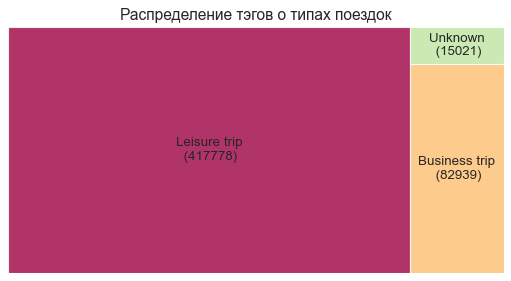

fig_10


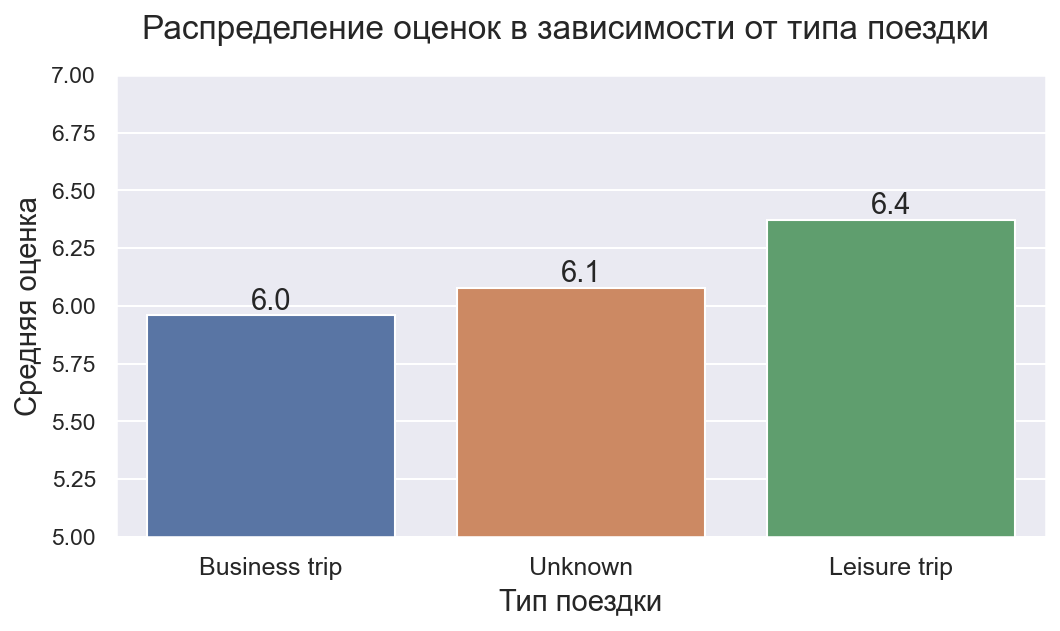

In [654]:
# Визуализация признака 
print(colored('fig_9', 'blue'))
chart_column_treemap(data, 'trip_type', 
                     'Распределение тэгов о типах поездок', size=[8, 4])

print(colored('fig_10', 'blue'))
chart_score_vs_column(data, 'trip_type', 
                      'Распределение оценок в зависимости от типа поездки', 
                      'Тип поездки', 
                      'Средняя оценка', 
                      size=[8, 4], ylim=[5, 7])

Путешественники отдыхающие в отпуску ставят оценки лучше, чем те кто останавливается в отеле по работе.

In [655]:
# Извлечем новый признак о способе загрузки информации
def from_mobile(tags_list):
    for element in tags_list:
        if 'Submitted from a mobile device' in element:
            return 1
    return 0

data['from_mobile'] = data['tags_list'].apply(from_mobile)

fig_11


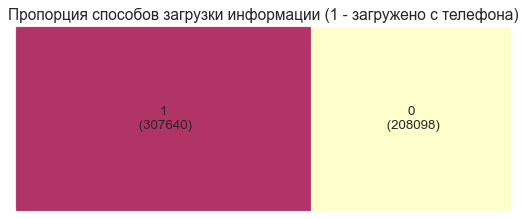

fig_12


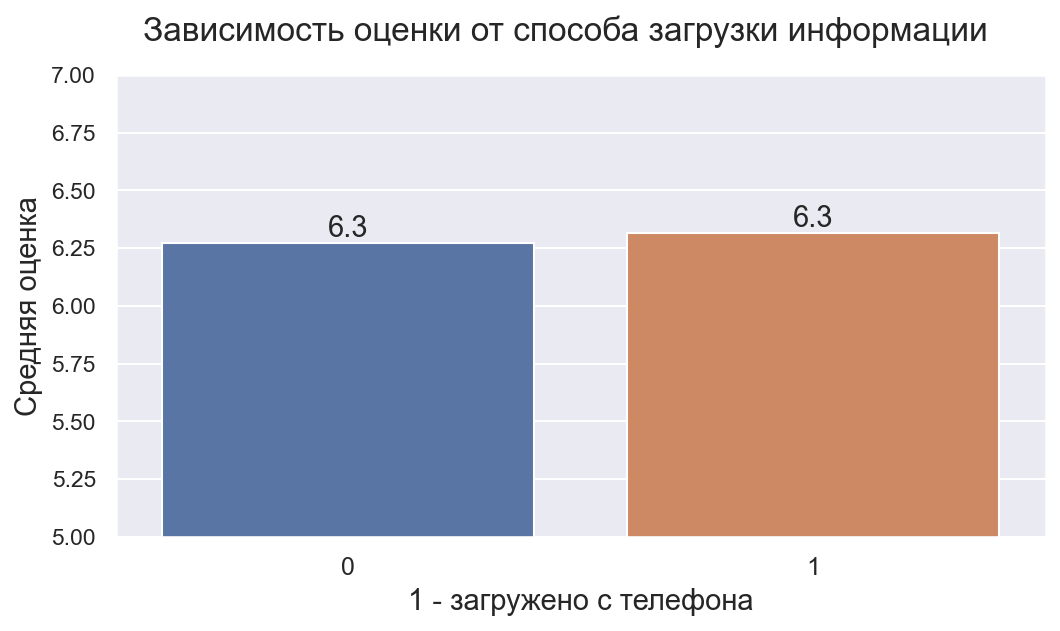

In [656]:

print(colored('fig_11', 'blue'))
chart_column_treemap(data, 'from_mobile', 
                     'Пропорция способов загрузки информации (1 - загружено с телефона)', size=[8, 3])

print(colored('fig_12', 'blue'))
chart_score_vs_column(data, 'from_mobile', 
                      'Зависимость оценки от способа загрузки информации', 
                      '1 - загружено с телефона', 
                      'Средняя оценка', 
                      size=[8, 4], ylim=[5, 7])

Оценка практически не зависит от того, с какого устройства писался отзыв об отеле

Выделим из тэгов тип компании путешественников. Создадим такие группы: 'Solo', 'Group', 'Couple', 'Family', 'Other'

In [657]:
def get_traveller_type(tags_list):
    for element in tags_list:
        if 'Solo' in element:
            return 'Solo'
        elif 'Group' in element:
            return 'Group'
        elif 'Couple' in element:
            return 'Couple'
        elif 'Family' in element:
            return 'Family'
    return 'Other'

data['traveller_type'] = data['tags_list'].apply(get_traveller_type)

In [658]:
data.traveller_type

0         Couple
1         Couple
2           Solo
3           Solo
4         Couple
           ...  
515733    Couple
515734    Couple
515735      Solo
515736      Solo
515737    Couple
Name: traveller_type, Length: 515738, dtype: object

fig_13


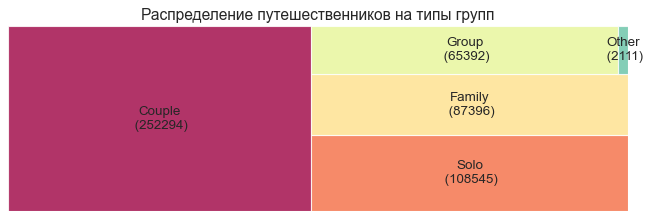

fig_14


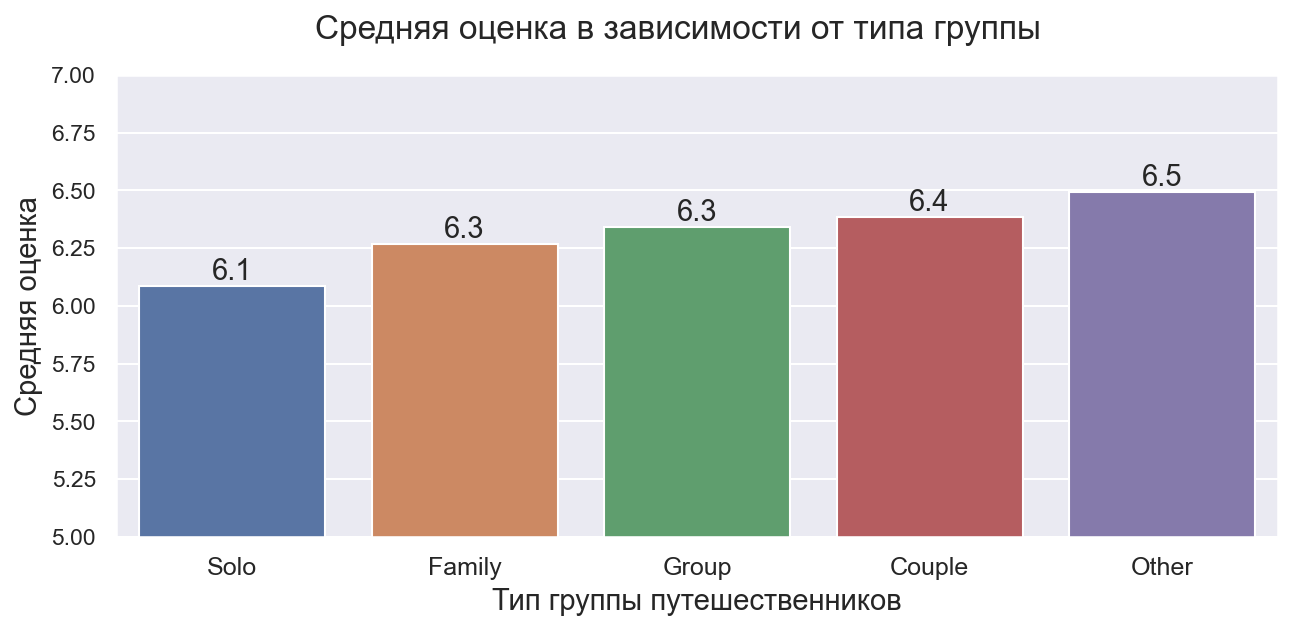

In [659]:
# Визуализация признака 
print(colored('fig_13', 'blue'))
chart_column_treemap(data, 'traveller_type', 
                     'Распределение путешественников на типы групп', size=[10, 3])

print(colored('fig_14', 'blue'))
chart_score_vs_column(data, 'traveller_type', 
                      'Средняя оценка в зависимости от типа группы', 
                      'Тип группы путешественников', 
                      'Средняя оценка', 
                      size=[10, 4], ylim=[5, 7])

Одинокие путешественники (видимо, останавливающиеся в отеле по работе) оставляют наихудшие отзывы

Выделим из тэгов информацию о продолжительности поездки

In [660]:
# Returns length of stay as string
def get_stay_length(tags_list):
    for element in tags_list:
        if 'night' in element and 'Stayed' in element:
            return element.split()[1]+' night(s)'
    return 0

data['stay_length'] = data['tags_list'].apply(get_stay_length)

Сокращаем количество категорий до 7 и Other.

In [661]:
data = reduce_categories_number(data, 'stay_length', 7)

fig_15


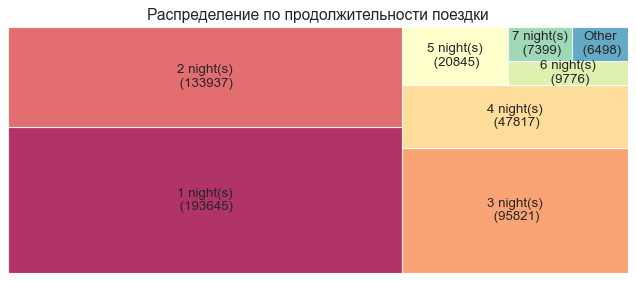

fig_16


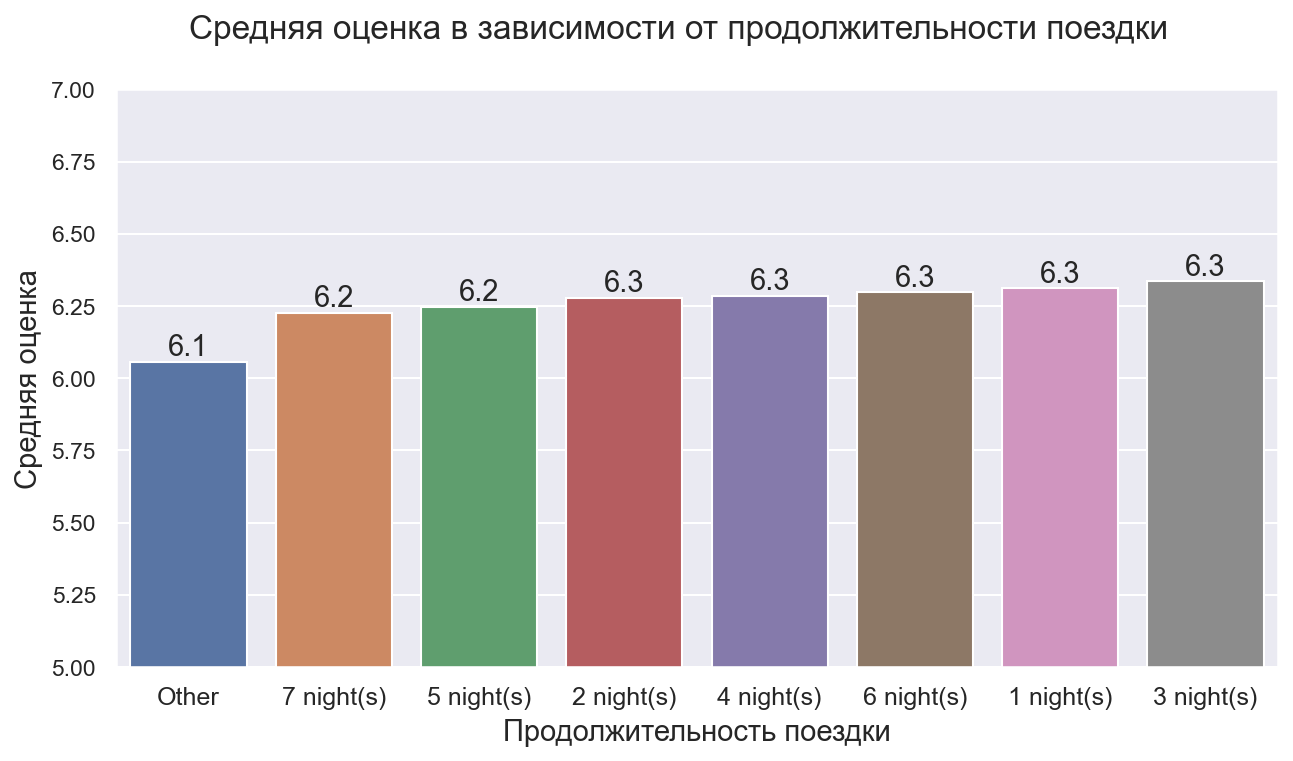

In [662]:
# Визуализация признака 
print(colored('fig_15', 'blue'))
chart_column_treemap(data, 'stay_length', 
                     'Распределение по продолжительности поездки', size=[10, 4])

print(colored('fig_16', 'blue'))
chart_score_vs_column(data, 'stay_length', 
                      'Средняя оценка в зависимости от продолжительности поездки', 
                      'Продолжительность поездки', 
                      'Средняя оценка', 
                      size=[10, 5], ylim=[5, 7])

Создадим признак типа комнаты

In [663]:
# Создадим тип комнаты
def get_room_type(tags_list):
    for element in tags_list:
        if 'Room' in element:
            return element
    return 'Other'

data['room_type'] = data['tags_list'].apply(get_room_type)

data = reduce_categories_number(data, 'room_type', 7)

fig_18


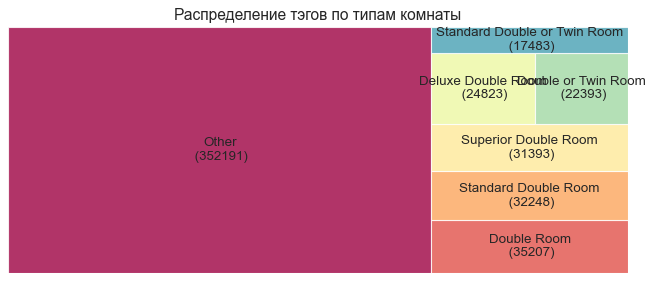

fig_19


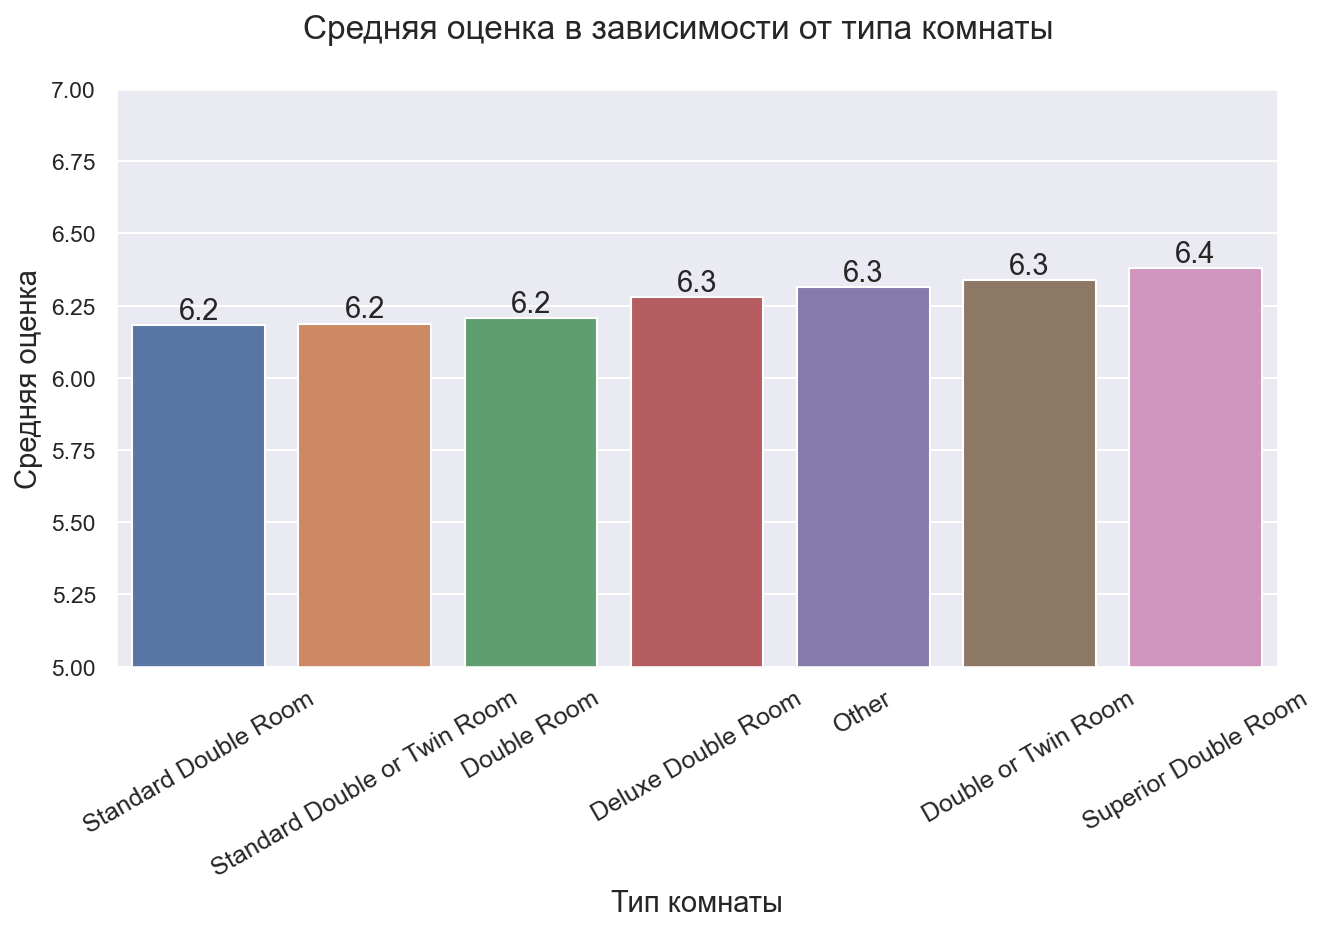

In [664]:
# Визуализация признака 
print(colored('fig_18', 'blue'))
chart_column_treemap(data, 'room_type', 
                     'Распределение тэгов по типам комнаты', size=[10, 4])

print(colored('fig_19', 'blue'))
chart_score_vs_column(data, 'room_type', 
                      'Средняя оценка в зависимости от типа комнаты', 
                      'Тип комнаты', 
                      'Средняя оценка', 
                      size=[10, 5], ylim=[5, 7], xticks_rotation=30)

In [665]:
print(colored('Новые признаки:', 'blue'))
data[['trip_type', 'from_mobile', 'traveller_type', 'stay_length', 'room_type']].head()

Новые признаки:


trip_type  from_mobile traveller_type stay_length  \
0   Leisure trip            1         Couple  2 night(s)   
1  Business trip            0         Couple  1 night(s)   
2   Leisure trip            1           Solo  3 night(s)   
3   Leisure trip            0           Solo  1 night(s)   
4  Business trip            0         Couple  6 night(s)   

                      room_type  
0                         Other  
1          Standard Double Room  
2                         Other  
3                         Other  
4  Standard Double or Twin Room

Оставляем всю полученную информацию и новые признаки для последующего анализа ее важности для нашей модели.

## <p style="border:5px solid Navy;text-align:center;font-size:100%;">2.5. Анализ и создание признаков из отзывов</p>
<div class="alert alert-primary" role="alert">

Как оказалось в последствии это самая важная для модели информация. Признаки непосредственно связанные с отзывами, содержат информацию о положительных и отрицательных отзывах.
Определим степень отрицательной и положительной окраски отзыва.
Для начала ознакомимся с признаком.

In [666]:
data['positive_review']

0                                                                                                                                              Staff were amazing
1                                                                                                                                                        location
2                                                                                                                                                     No Positive
3                                                                                      Friendly staff quiet comfortable room spotlessly clean excellent location 
4                                              The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious 
                                                                                   ...                                                                           
515733                      

In [667]:
data['negative_review']

0                                                                                                                                                                      Leaving 
1                                                                                                                                                                poor breakfast
2                                                                                                                                                            No kettle in room 
3                                                                                                                                                                   No Negative
4                                                                                                                                                                  Torn sheets 
                                                                                          ...                           

In [668]:
print(colored('Самые распространенные значения отрицательных отзывов:', 'blue'))
display(data['negative_review'].value_counts().head(25))

print(colored('Самые распространенные значения положительных отзывов:', 'blue'))
display(data['positive_review'].value_counts().head(25))

Самые распространенные значения отрицательных отзывов:


No Negative            127890
 Nothing                14295
 Nothing                 4236
 nothing                 2225
 N A                     1037
 None                     984
                          849
 N a                      509
 Breakfast                407
 Small room               373
 Location                 368
 Everything               326
 All good                 318
 Nothing really           316
 none                     302
 nothing                  283
 No complaints            274
 Price                    260
 Nothing really           254
 Nil                      247
 n a                      227
 Nothing at all           221
 Nothing to dislike       209
 Nothing at all           194
 Small rooms              188
Name: negative_review, dtype: int64

Самые распространенные значения положительных отзывов:


No Positive            35946
 Location               9222
 Everything             2284
 location               1677
 Nothing                1243
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
 Location and staff      333
 everything              319
 Good location           276
 Nothing                 225
 Comfy bed               222
 nothing                 217
 The location            215
 good location           206
 The staff               197
 Good breakfast          189
Name: positive_review, dtype: int64

Выходит, что в колонке с положительными отзывами попадаются явно негативные отзывы (например: 'No Positive'). И наоборот - в негативных отзывах присутствуют положительные отзывы (напрмер: 'No Negative'). Отметим эти нюансы новым признаком. 0 - будет явно негативным отзывом, а 1 - положительным отзывом.

In [669]:
def from_negative_positive(negative_review):
    if 'No Negative' in negative_review:
        return 1
    elif 'Nothing' in negative_review:
        return 1
    elif 'nothing' in negative_review:
        return 1
    elif 'None' in negative_review:
        return 1
    elif 'N A' in negative_review:
        return 1
    elif 'N a' in negative_review:
        return 1
   
    else:
        return 0
      
data['from_negative_positive'] = data['negative_review'].apply(from_negative_positive)
print(colored('отметим явный положительный отзыв как 1, остальные негативные отзывы будут иметь 0:', 'blue'))
data['from_negative_positive'].value_counts()



отметим явный положительный отзыв как 1, остальные негативные отзывы будут иметь 0:


0    346454
1    169284
Name: from_negative_positive, dtype: int64

In [670]:
def from_positive_negative(positive_review):
    if 'no positive' in positive_review:
        return 0
    elif 'nothing' in positive_review:  
        return 0
    elif 'No Positive' in positive_review:
        return 0
    else:
        return 1
      
data['from_positive_negative'] = data['positive_review'].apply(from_positive_negative)
print('отметим явный негативный отзыв как 0, остальные положительные отзывы будут иметь значение 1:')
data['from_positive_negative'].value_counts()

отметим явный негативный отзыв как 0, остальные положительные отзывы будут иметь значение 1:


1    476571
0     39167
Name: from_positive_negative, dtype: int64

Попробуем добавить еще один признак, в котором мы суммировали обе предыдущие колонки. На этапе отбора признаков посмотрим насколько они эффективны.

In [671]:
data['real_evaluation'] = data['from_positive_negative'] + data['from_negative_positive']
data['real_evaluation']

0         1
1         1
2         0
3         2
4         1
         ..
515733    2
515734    2
515735    1
515736    2
515737    0
Name: real_evaluation, Length: 515738, dtype: int64

Скорректируем явно негативные и явно позитивные отзывы. Я выделил 8 пар отзывов из самых распространенных положительные и негативных отзывов. Експерименатльно убедился, что большее количество пар приводит у ухудшению метрики. Оставил самые популярные три пары.

In [672]:
# создаем временные колонки
data['negative_review_temp'] = data['negative_review']
data['positive_review_temp'] = data['positive_review']

# cкорректируем негативные отзывы в позитивные
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('Nothing', 'Positive'))
#data['negative_review_temp'] = data['negative_review_temp'].apply(
 #   lambda x: x.replace('N a', 'Positive'))
#data['negative_review_temp'] = data['negative_review_temp'].apply(
#    lambda x: x.replace('n a', 'Positive'))
#data['negative_review_temp'] = data['negative_review_temp'].apply(
#    lambda x: x.replace('All good', 'Positive'))
#data['negative_review_temp'] = data['negative_review_temp'].apply(
#    lambda x: x.replace('No complaints', 'Positive'))
#data['negative_review_temp'] = data['negative_review_temp'].apply(
#    lambda x: x.replace('Nothing to dislike', 'Positive'))

#скорректируем позитивные в негативные
data['positive_review_temp'] = data['positive_review_temp'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

In [673]:
%%time
# переведём текст в нижний регистр и преобразуем строку в словарь
data['negative_review_list'] = data['negative_review_temp'].apply(
            lambda x: x.lower().split())
data['positive_review_list'] = data['positive_review_temp'].apply(
            lambda x: x.lower().split())

# удалим не текстовые символы
data['negative_review_list'] = data['negative_review_list'].apply(
            lambda x: [word for word in x if word.isalpha()])
data['positive_review_list'] = data['positive_review_list'].apply(
            lambda x: [word for word in x if word.isalpha()])

# преобразуем список в строку
data['negative_review_temp'] = data['negative_review_list'].apply(
            lambda x: ' '.join(x))
data['positive_review_temp'] = data['positive_review_list'].apply(
            lambda x: ' '.join(x))

data['negative_review_word_counts'] = data['negative_review_list'].apply(
            lambda x: len(x))
data['positive_review_word_counts'] = data['positive_review_list'].apply(
            lambda x: len(x))

data = data.drop(['negative_review_list','positive_review_list'], axis = 1)

CPU times: total: 9.08 s
Wall time: 9.22 s


In [674]:
# создаем два экземпляра анализатора, для позитивной и негаивной оценки 
positive_analyzer = SentimentIntensityAnalyzer()
negative_analyzer = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
word = 'positive'
print(colored('Словарь оценок слова "{}" до преобразований:'.format(word), 'blue'))
print(negative_analyzer.polarity_scores(word), '\n')

# добавим контекст:
negative_words = {'small': -1, 'nothing': 10}
positive_words = {'nothing': -10, 'everything': 10}
negative_analyzer.lexicon.update(negative_words)
positive_analyzer.lexicon.update(positive_words)

# посмотрим результат
print(colored('После преобразований negative":', 'blue'))
print(negative_analyzer.polarity_scores(word), '\n')
print(colored('После преобразований "positive":', 'blue'))
print(positive_analyzer.polarity_scores(word))

Словарь оценок слова "positive" до преобразований:
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574} 

После преобразований negative":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574} 

После преобразований "positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [675]:
%%time
data['negative_review_grade'] = data['negative_review_temp'].apply(
    lambda x: negative_analyzer.polarity_scores(x))
data['positive_review_grade'] = data['positive_review_temp'].apply(
    lambda x: positive_analyzer.polarity_scores(x))

# формируем новые признаки:
data['negative_review_neg'] = data['negative_review_grade'].apply(
    lambda x: x['neg'])
data['negative_review_neu'] = data['negative_review_grade'].apply(
    lambda x: x['neu'])
data['negative_review_pos'] = data['negative_review_grade'].apply(
    lambda x: x['pos'])
data['negative_review_compound'] = data['negative_review_grade'].apply(
    lambda x: x['compound'])

data['positive_review_neg'] = data['positive_review_grade'].apply(
    lambda x: x['neg'])
data['positive_review_neu'] = data['positive_review_grade'].apply(
    lambda x: x['neu'])
data['positive_review_pos'] = data['positive_review_grade'].apply(
    lambda x: x['pos'])
data['positive_review_compound'] = data['positive_review_grade'].apply(
    lambda x: x['compound'])

# удалим временные столбцы
data = data.drop(['negative_review_grade','positive_review_grade',
                  'negative_review_temp','positive_review_temp'], 
                  axis=1)

CPU times: total: 2min 56s
Wall time: 2min 57s


In [676]:
data[['positive_review_neg', 'positive_review_neu', 'positive_review_pos', 'positive_review_compound']]

positive_review_neg  positive_review_neu  positive_review_pos  \
0                     0.000                0.345                0.655   
1                     0.000                1.000                0.000   
2                     1.000                0.000                0.000   
3                     0.000                0.279                0.721   
4                     0.000                0.618                0.382   
...                     ...                  ...                  ...   
515733                0.000                0.263                0.737   
515734                0.000                0.615                0.385   
515735                0.000                0.753                0.247   
515736                0.000                0.584                0.416   
515737                1.000                0.000                0.000   

        positive_review_compound  
0                          0.586  
1                          0.000  
2                         -0.572  
3                          0.917  
4                          0.850  
...                          ...  
515733                     0.421  
515734                     0.917  
515735                     0.762  
515736                     0.839  
515737                    -0.572  

[515738 rows x 4 columns]

Построим визуализацию

In [677]:
# Задаем словарь с параметрами
#data_dict = {
#    0: ['negative_review_neg', 'positive_review_neg', 500000, 'Негативные оценки'],
    # 1: ['negative_review_pos', 'positive_review_pos', 300000, 'Позитивные оценки'],
    # 2: ['negative_review_neu', 'positive_review_neu', 190000, 'Нейтральные оценки'],
    # 3: ['negative_review_compound', 'positive_review_compound', 330000, 'Комбинированные оценки']
# }

# строим графики
# afig, axes = plt.subplots(1, 4, figsize=(20, 5))
# plt.subplots_adjust(wspace=.15)

# for i in data_dict:
    # sns.histplot(data=data[[data_dict[i][0], data_dict[i][1]]], 
                #  bins=10, 
                #  ax=axes[i], 
                #  kde=True)
    # axes[i].set_title(data_dict[i][3], 
                    #   fontsize=12)
    # axes[i].set_xlabel('Значение')
    # axes[i].set_ylabel('Количество')
    # axes[i].legend(labels=['Негативный отзыв','Позитивный отзыв'])
    # axes[i].set_yticks([])
    # axes[i].axes.set_ylim(0, data_dict[i][2])

# plt.show()

Поскольку сведения достаточно специфичны, оставим как есть. В даной работе пробовал обрабатывать выбросы, что приводило к ухудшению метрики. 


Сформируем мешок слов. Создим для каждого уникального слова категориальную переменную. Учитывая большое количество слов ограничимся 32 наиболее часто встречающимися словами.

In [678]:
# подготовим данные 
# переведём текст в нижний регистр и преобразуем строку в словарь
data['negative_review'] = data['negative_review'].apply(
            lambda x: x.lower().split())
data['positive_review'] = data['positive_review'].apply(
            lambda x: x.lower().split())

# удалим не текстовые символы
data['negative_review'] = data['negative_review'].apply(
            lambda x: [word for word in x if word.isalpha()])
data['positive_review'] = data['positive_review'].apply(
            lambda x: [word for word in x if word.isalpha()])


# преобразуем список в строку
data['negative_review'] = data['negative_review'].apply(lambda x: ' '.join(x))
data['positive_review'] = data['positive_review'].apply(lambda x: ' '.join(x))

In [679]:
data, bow_neg = add_bag_of_words(data, 'negative_review', 'bow_n_')
data, bow_pos = add_bag_of_words(data, 'positive_review', 'bow_p_')

In [680]:
# Посмотрим на содержимое мешков слов 

max_length = 8

for word_length in range(0, max_length+1):
    if word_length >= 2:
        print('Negative BoW с количеством слов:', word_length)
    
    if word_length < max_length:
        print([word for word in bow_neg if len(word)==word_length])
    else:
        print([word for word in bow_neg if len(word)>=word_length])

print('')

for word_length in range(0, max_length+1):
    if word_length >= 2:
        print('Positive BoW с количеством слов:', word_length)
    
    if word_length < max_length:
        print([word for word in bow_pos if len(word)==word_length])
    else:
        print([word for word in bow_pos if len(word)>=word_length])

[]
[]
Negative BoW с количеством слов: 2
['as', 'at', 'be', 'in', 'is', 'it', 'no', 'of', 'on', 'to', 'we']
Negative BoW с количеством слов: 3
['and', 'but', 'for', 'had', 'not', 'the', 'was', 'you']
Negative BoW с количеством слов: 4
['from', 'have', 'room', 'that', 'they', 'very', 'were', 'with']
Negative BoW с количеством слов: 5
['hotel', 'small', 'there']
Negative BoW с количеством слов: 6
[]
Negative BoW с количеством слов: 7
[]
Negative BoW с количеством слов: 8
['breakfast', 'negative']

[]
[]
Positive BoW с количеством слов: 2
['at', 'in', 'is', 'it', 'no', 'of', 'to', 'we']
Positive BoW с количеством слов: 3
['and', 'bed', 'for', 'the', 'was']
Positive BoW с количеством слов: 4
['from', 'good', 'nice', 'room', 'very', 'were', 'with']
Positive BoW с количеством слов: 5
['clean', 'great', 'hotel', 'rooms', 'staff']
Positive BoW с количеством слов: 6
[]
Positive BoW с количеством слов: 7
['helpful']
Positive BoW с количеством слов: 8
['breakfast', 'comfortable', 'excellent', 'fr

Проведем анализ при помощи библиотеки TextBlob, используемой для анализа целого предложения, выдавая такие параметры как: полярность и субъективность.
Для оценки настроения рецензента будем использовать оба параметра.
Поскольку бибилиотека работает со строкой и оценивает полярность и субъективность текста в целом, предварительные преообразования текста не нужны.

In [681]:
%%time

# получим полярность и субъективность
def get_polarity(text):
    """ Функция получения параметра полярности отзыва 
    
    Args:
        string (str): строка, передаваемая в обработку

    Returns:
        str: возвращает значение параметра полярности
    """
    blob = TextBlob(text)
    return blob.sentiment_assessments.polarity

def get_subjectivity(text):
    """ Функция получения параметра субъективности отзыва 
    
    Args:
        string (str): строка, передаваемая в обработку

    Returns:
        str: возвращает значение параметра субъективности
    """
    blob = TextBlob(text)
    return blob.sentiment_assessments.subjectivity
# добавим новые признаки к нашим данным
data['positive_polarity'] = data['positive_review'].apply(get_polarity)
data['negative_polarity'] = data['negative_review'].apply(get_polarity)
data['positive_subjectivity'] = data['positive_review'].apply(get_subjectivity)
data['negative_subjectivity'] = data['negative_review'].apply(get_subjectivity)

CPU times: total: 9min 13s
Wall time: 9min 13s


Визуализируем полученные результаты

In [682]:
# Задаем словарь с параметрами
#data_dict = {
#    0: ['negative_polarity', 'positive_polarity', 645000, 'Полярность оценок'],
#    1: ['negative_subjectivity', 'positive_subjectivity', 360000, 'Субъективность оценок'],
#}

# строим графики
#afig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.subplots_adjust(wspace=.15)

#for i in data_dict:
#    sns.histplot(data=data[[data_dict[i][0], data_dict[i][1]]], 
#                 bins=10, 
#                 ax=axes[i], 
#                 kde=True)
#    axes[i].set_title(data_dict[i][3], 
#                      fontsize=12)
#    axes[i].set_xlabel('Значение')
#    axes[i].set_ylabel('Количество')
#    axes[i].legend(labels=['Негативный отзыв','Позитивный отзыв'])
#    axes[i].set_yticks([])
#    axes[i].axes.set_ylim(0, data_dict[i][2])

Построим оценку при помощи библиотеки Afinn, котрая строит некоторую оценку, взвешенную по количеству слов:

In [683]:
%%time
# получаем счет:
afinn = Afinn()
data['positive_afinn'] = data['positive_review'].apply(
    lambda x: afinn.score(x))
data['negative_afinn'] = data['negative_review'].apply(
    lambda x: afinn.score(x))

CPU times: total: 7min 49s
Wall time: 7min 49s


Визуализируем результат

In [684]:
# строим графики
#afig, axes = plt.subplots(3, 1, figsize=(8, 20))

#sns.histplot(data=data[['negative_afinn','positive_afinn']], 
 #            bins=50, 
  #           ax=axes[0], 
   #          kde=True)
#axes[0].set_title('Взвешенная оценка', fontsize=12)
#axes[0].set_xlabel('Значение')
#axes[0].set_ylabel('Количество')
#axes[0].legend(labels=['Негативный отзыв','Позитивный отзыв'])
#axes[0].set_yticks([])

#sns.boxplot(data['positive_afinn'], 
#            ax=axes[1], 
#            orient='h', 
#            medianprops={"color": "red", "linestyle": '--'})
#axes[1].set(ylabel='')
#axes[1].set_title('Взвешенная позитивная оценка')

#sns.boxplot(data['negative_afinn'], ax=axes[2], orient='h', medianprops={"color": "red", "linestyle": '--'})
#axes[2].set(ylabel='')
#axes[2].set_title('Взвешенная негативная оценка')

#plt.show()

Эксперементально убедился, что при обработке выбросов ухудшаются показатели метрики, поэтому оставим как есть.

Использовали одновременно три способа анализа при помощи:
* NLTK;
* TextBlob;
* Afinn 

А также воспользовались моделью "мешка слов". Эффективность преобразований оценим на этапе отбора признаков и вычислительных экспериментов.

In [685]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Columns: 113 entries, hotel_address to negative_afinn
dtypes: float64(18), int64(81), object(14)
memory usage: 444.6+ MB


In [686]:
# создадим дубликат данных для дальнейших манипуляций со столбцами (для обратимости экспериментов):
data.to_csv('final_3_1_2.csv')

# <p style="border:5px solid Navy;text-align:center;font-size:100%;">3.Отбор признаков</p>
<div class="alert alert-primary" role="alert">

В этом разделе удалим все признаки, которые не планируем использовать в работе модели. А также те, которые ухудшают результаты метрики.

In [774]:

# создаем дубликат базы для дальнейших манипуляций со столбцами (для обратимости экспериментов):
df = pd.read_csv('final_3_1_2.csv', index_col=[0])

In [775]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Columns: 113 entries, hotel_address to negative_afinn
dtypes: float64(18), int64(81), object(14)
memory usage: 448.6+ MB


In [776]:
# посмотрим признаки с не числовыми типами данных
def getNonNumberTypeFeatures(df):
    """Функция возвращает в списке все признаки из датасета, что подходят под описанные правила

    Args:
        df (pandas.Dataframe()): Датасет

    Returns:
        list: Список признаков
    """
    object_columns = [s for s in df.columns
                    if ((df[s].dtypes == 'object') | \
                        (df[s].dtype.name == 'category') | \
                        (df[s].dtypes == 'datetime64[ns]') |
                        (df[s].dtype.name == 'period[M]'))]
    return object_columns

types_list = getNonNumberTypeFeatures(df)
print(Fore.LIGHTCYAN_EX + "Количество признаков, которые надо удалить, либо обработать:", types_list.__len__(), 'признаков')
display(types_list)

Количество признаков, которые надо удалить, либо обработать: 14 признаков


['hotel_address',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review',
 'hotel_country',
 'hotel_city',
 'tags_list',
 'trip_type',
 'traveller_type',
 'stay_length',
 'room_type']

In [777]:
#закодируем оставшиеся категориальные признаки

encoder = ce.OneHotEncoder(cols=['room_type'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['room_type'])
df = pd.concat([df, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['stay_length'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['stay_length'])
df = pd.concat([df, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['traveller_type'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['traveller_type'])
df = pd.concat([df, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['trip_type'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['trip_type'])
df = pd.concat([df, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['hotel_country'])
df = pd.concat([df, type_bin], axis=1)


encoder = ce.OneHotEncoder(cols=['reviewer_nationality'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['reviewer_nationality'])
df = pd.concat([df, type_bin], axis=1)


In [778]:
# удалим все не нужные признаки
drop_list = ['hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review',
 'hotel_address',
 'hotel_country',
 'hotel_city',
 'tags_list',
 'trip_type',
 'traveller_type',
 'stay_length',
 'room_type']

df.drop(drop_list, axis = 1, inplace=True)

In [779]:
# В итоге имеем датасет числовых признаков подходящих для построения модели
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Columns: 140 entries, average_score to reviewer_nationality_ Saudi Arabia 
dtypes: float64(18), int64(122)
memory usage: 554.8 MB


Получилось много колонок. Поделим признаки на две группы и построим визуализацию корреляций признаков

In [780]:
final_columns = list(df.columns.values )



In [781]:
# признаки, которые относятся к описанию отелей
cat_col = [ 
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'sample',
 'is_in_chain',
 'month',
 'number_of_tags',
 'negative_review_word_counts',
 'positive_review_word_counts',
 'room_type_Standard Double Room',
 'stay_length_1 night(s)',
 'stay_length_3 night(s)',
 'stay_length_Other',
 'traveller_type_Couple',
 'traveller_type_Solo',
 'trip_type_Business trip',
 'trip_type_Unknown',
 'hotel_country_United Kingdom',
 'hotel_country_Austria',
 'hotel_country_Spain',
 'reviewer_nationality_ United Kingdom ',
 'reviewer_nationality_Other',
 'reviewer_nationality_ France ',
 'reviewer_nationality_ Switzerland ',
 'reviewer_nationality_ United Arab Emirates ',
 'reviewer_nationality_ United States of America ',
 'reviewer_nationality_ Netherlands ',
 'reviewer_nationality_ Canada ',
 'reviewer_nationality_ Germany ',
 'reviewer_nationality_ Australia ',
 'reviewer_nationality_ Saudi Arabia ']


In [782]:
# признаки, относяшиеся к оценке отзывов 
lingvo_col = ['negative_review_neg',
 'negative_review_neu',
 'negative_review_pos',
 'negative_review_compound',
 'positive_review_neg',
 'positive_review_neu',
 'positive_review_pos',
 'positive_review_compound',
 'bow_n_and',
 'bow_n_as',
 'bow_n_at',
 'bow_n_be',
 'bow_n_breakfast',
 'bow_n_but',
 'bow_n_for',
 'bow_n_from',
 'bow_n_had',
 'bow_n_have',
 'bow_n_hotel',
 'bow_n_in',
 'bow_n_is',
 'bow_n_it',
 'bow_n_negative',
 'bow_n_no',
 'bow_n_not',
 'bow_n_of',
 'bow_n_on',
 'bow_n_room',
 'bow_n_small',
 'bow_n_that',
 'bow_n_the',
 'bow_n_there',
 'bow_n_they',
 'bow_n_to',
 'bow_n_very',
 'bow_n_was',
 'bow_n_we',
 'bow_n_were',
 'bow_n_with',
 'bow_n_you',
 'bow_p_and',
 'bow_p_at',
 'bow_p_bed',
 'bow_p_breakfast',
 'bow_p_clean',
 'bow_p_comfortable',
 'bow_p_excellent',
 'bow_p_for',
 'bow_p_friendly',
 'bow_p_from',
 'bow_p_good',
 'bow_p_great',
 'bow_p_helpful',
 'bow_p_hotel',
 'bow_p_in',
 'bow_p_is',
 'bow_p_it',
 'bow_p_location',
 'bow_p_nice',
 'bow_p_no',
 'bow_p_of',
 'bow_p_positive',
 'bow_p_room',
 'bow_p_rooms',
 'bow_p_staff',
 'bow_p_the',
 'bow_p_to',
 'bow_p_very',
 'bow_p_was',
 'bow_p_we',
 'bow_p_were',
 'bow_p_with',
 'positive_polarity',
 'negative_polarity',
 'positive_subjectivity',
 'negative_subjectivity',
 'positive_afinn',
 'negative_afinn',
 ]


In [783]:
# сформируем список для признаков, которые мы удалим в процессе оценки их значимости для модели
df_drop = []

Посторим тепловую карту для анализа корреляций между признаками

In [784]:
def chart_correlation_heatmap(df, 
                              columns, 
                              title, 
                              method='pearson', 
                              correlation_threshold=.7):
    """Построение корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    correlation_matrix = df[columns].corr(method=method).abs()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix[correlation_matrix.abs() > correlation_threshold], 
                annot=True,
                annot_kws={"fontsize":7}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='GnBu',
                fmt='.2f')
    ax_.set_title(title, fontsize=18)
    plt.show()

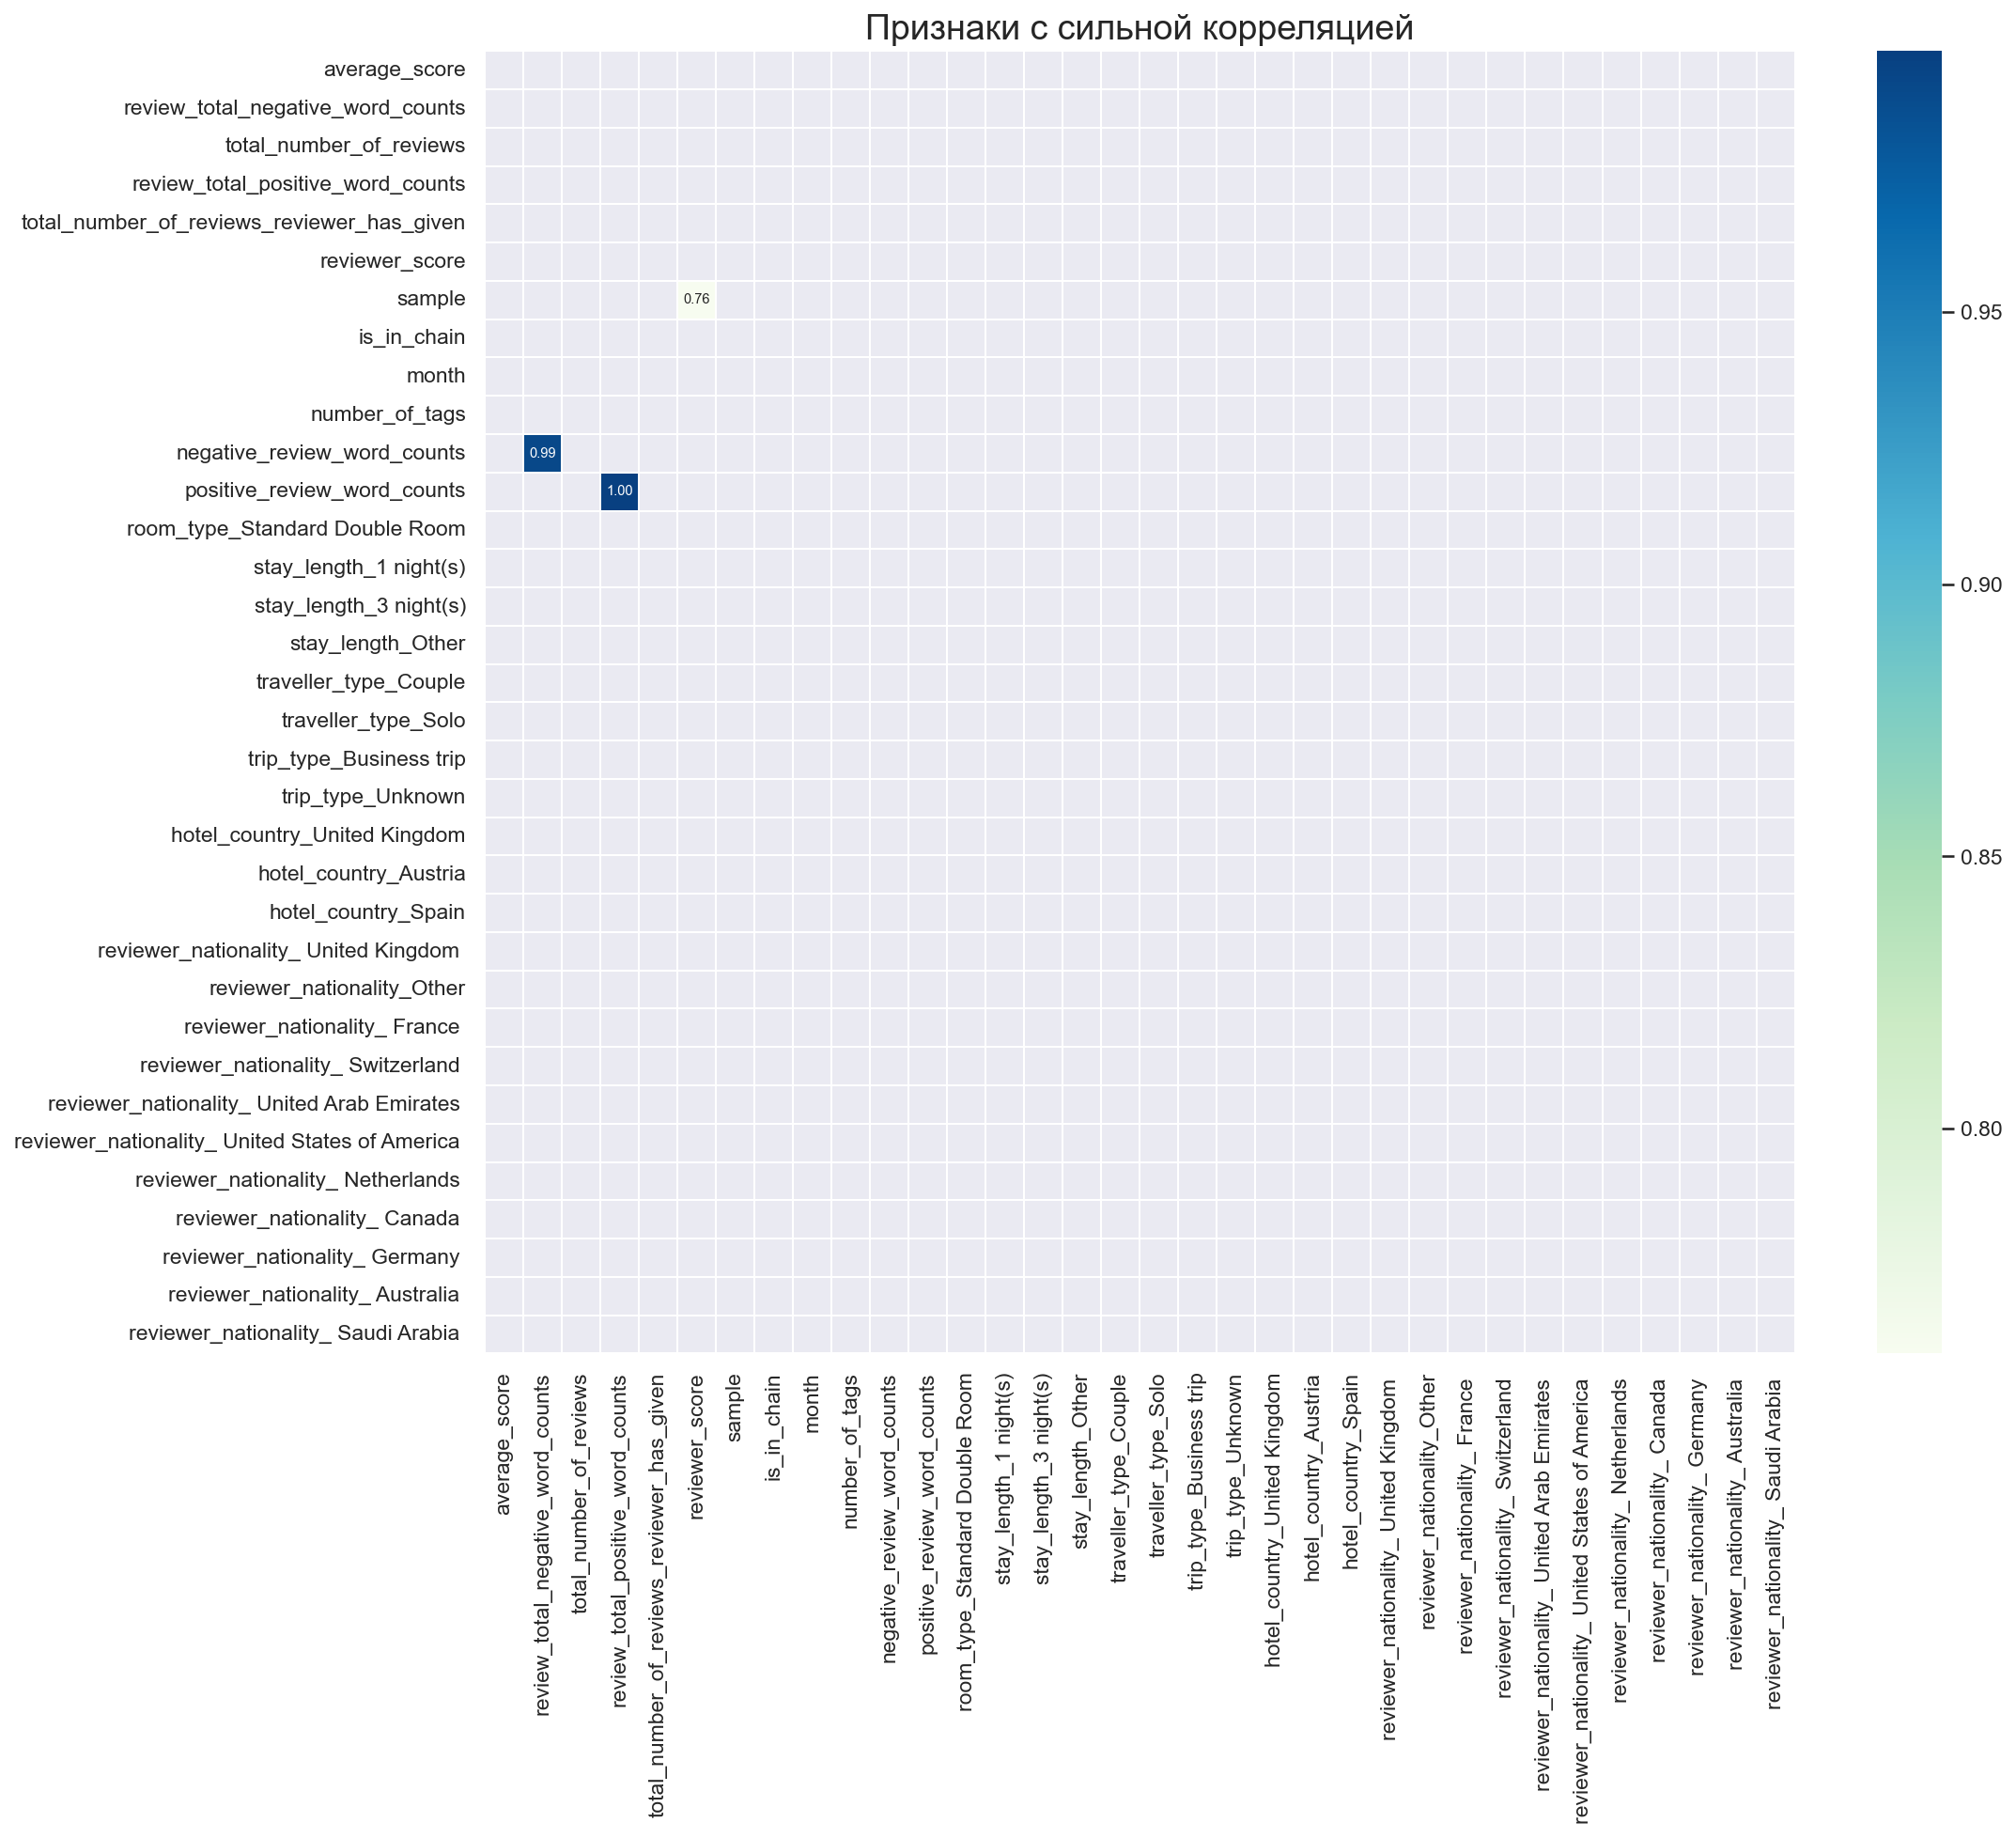

In [785]:
#строим тепловую карту корреляций при помощи служебной функции. Можно вписать метод и границы корреляции, чтобы не выводить все значения признаков
chart_correlation_heatmap(df, cat_col, 'Признаки с сильной корреляцией', method='spearman')

In [786]:
# выведем в все признаки с высокой корреляцией отдельно

corr = df[cat_col].corr(method='spearman')
print(colored('Наиболее высокая корреляция между признаками:', 'blue'))
corr_unstack = corr.abs().unstack().reset_index()

corr_unstack = corr_unstack.rename(columns = {'level_0' : 'feature 1', 'level_1' : 'feature 2',0 : 'Corr ind' }).\
     sort_values(by = 'Corr ind', ascending = False)
corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr ind'] > .7))].\
  iloc[0::2,:].reset_index(drop = True)

Наиболее высокая корреляция между признаками:


feature 1                          feature 2  \
0  review_total_positive_word_counts        positive_review_word_counts   
1        negative_review_word_counts  review_total_negative_word_counts   
2                     reviewer_score                             sample   

   Corr ind  
0     0.998  
1     0.992  
2     0.759

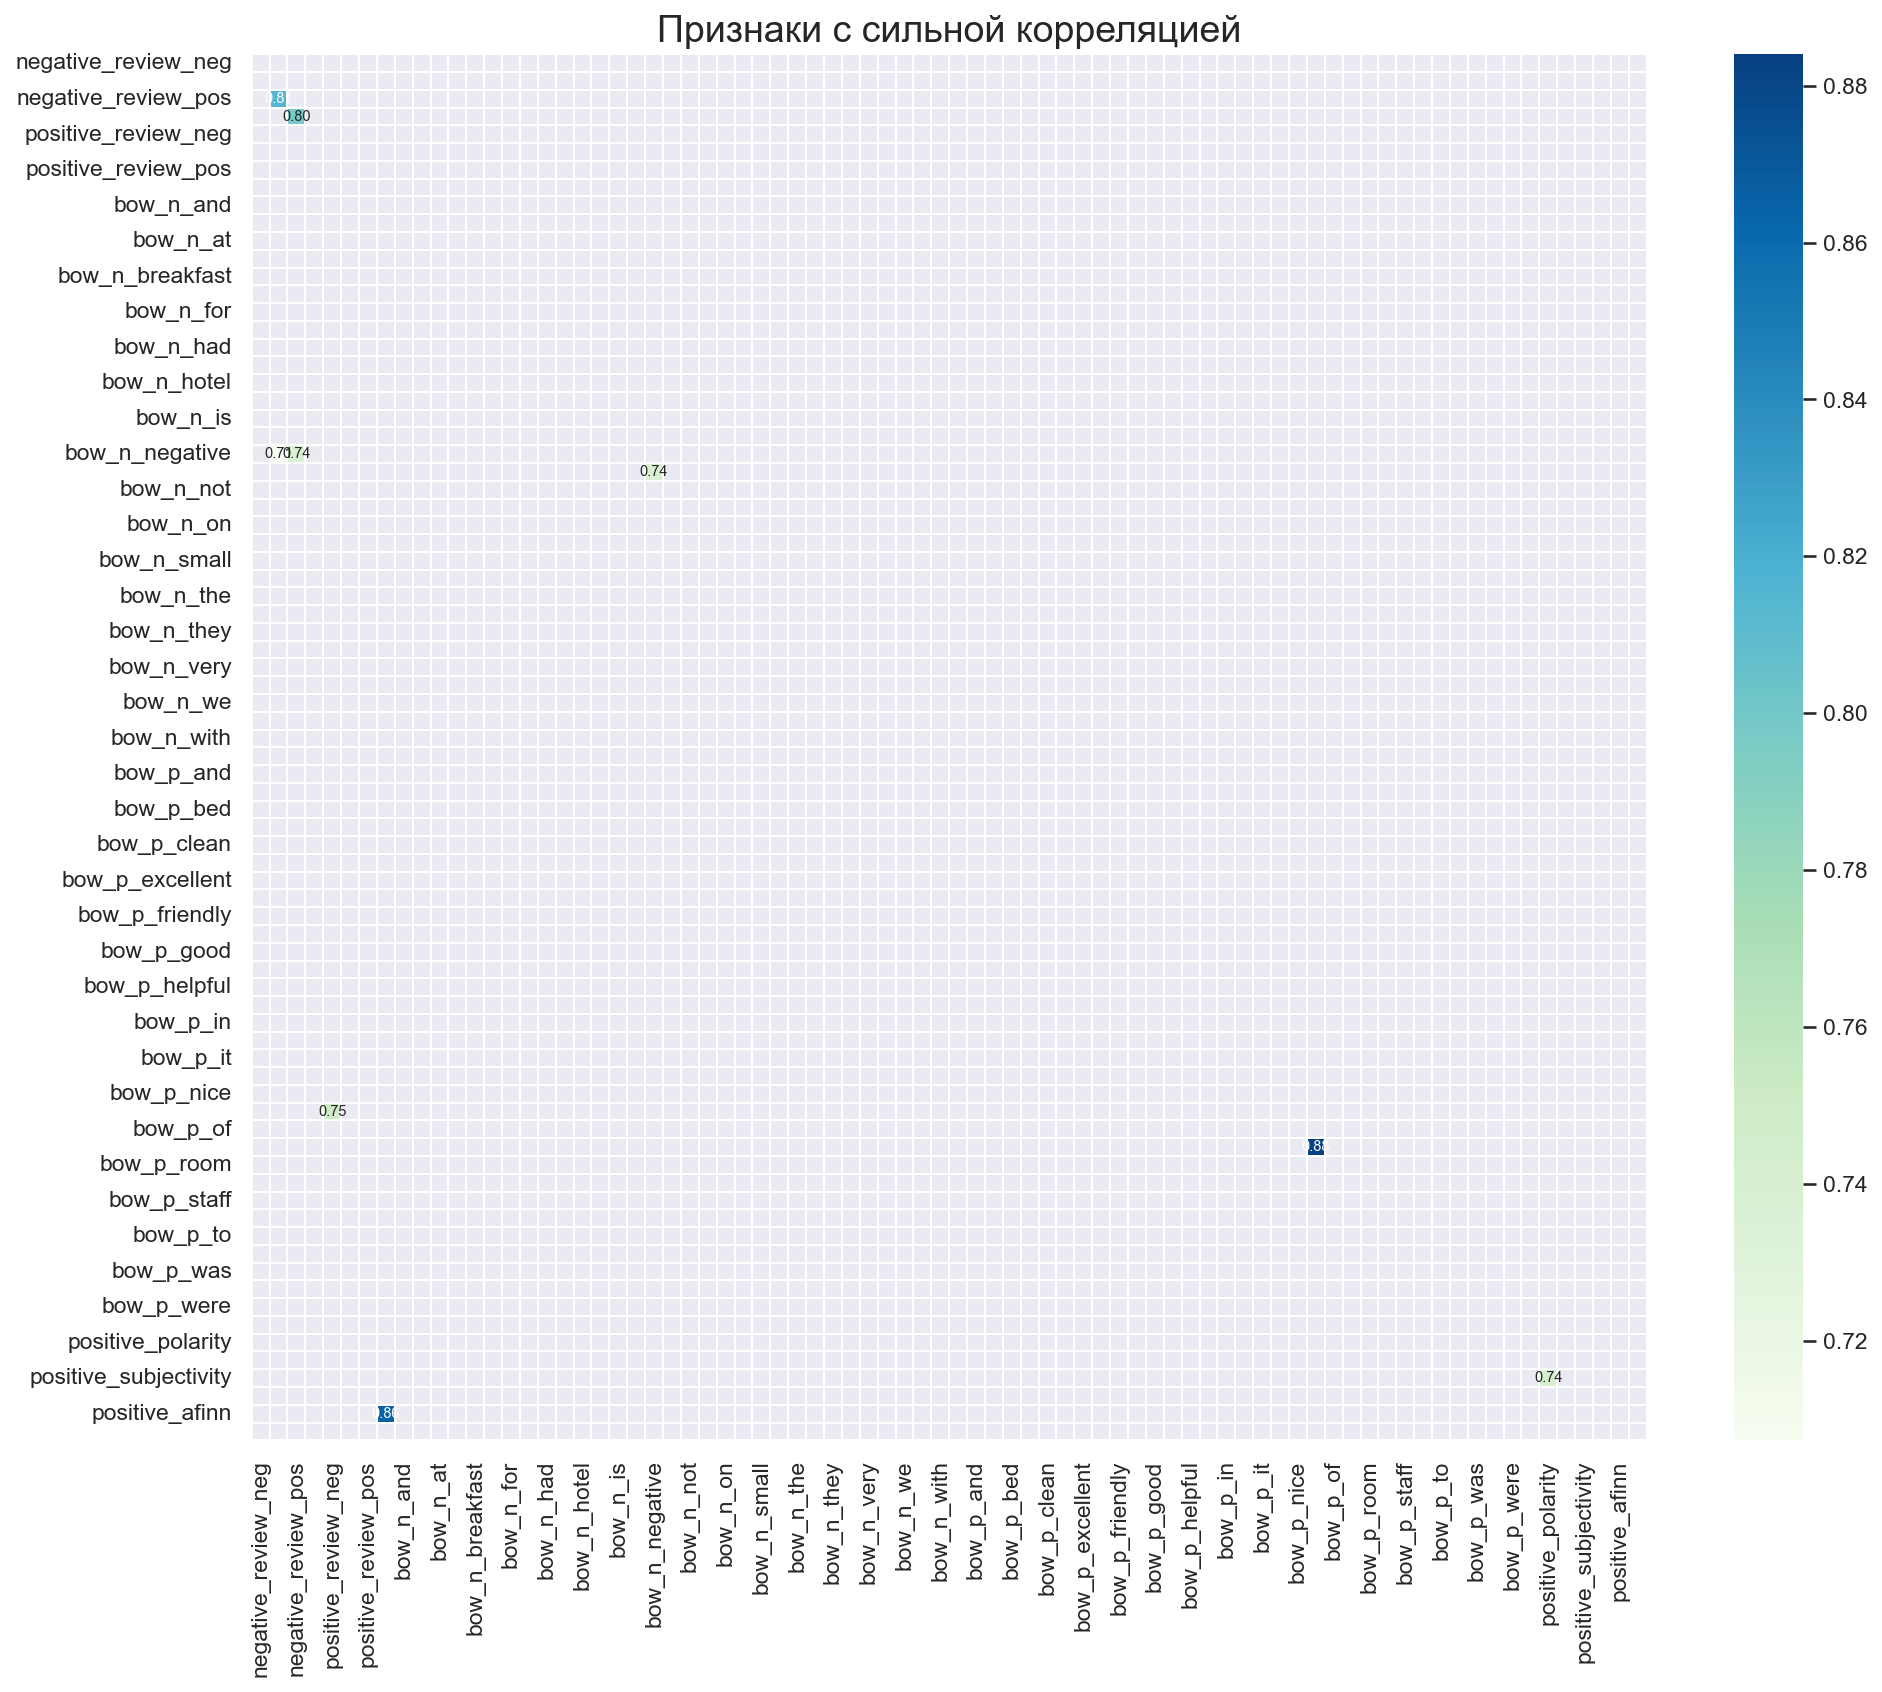

In [787]:
#строим тепловую карту корреляций числовых признаков при помощи служебной функции
chart_correlation_heatmap(df, lingvo_col, 'Признаки с сильной корреляцией', method='spearman')

In [788]:
# выведем в все признаки с высокой корреляцией отдельно

corr = df[lingvo_col].corr(method='spearman')
print(colored('Наиболее высокая корреляция между признаками:', 'blue'))
corr_unstack = corr.abs().unstack().reset_index()

corr_unstack = corr_unstack.rename(columns = {'level_0' : 'feature 1', 'level_1' : 'feature 2',0 : 'Corr ind' }).\
     sort_values(by = 'Corr ind', ascending = False)
corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr ind'] > .7))].\
  iloc[0::2,:].reset_index(drop = True)

Наиболее высокая корреляция между признаками:


feature 1                 feature 2  Corr ind
0                  bow_p_no            bow_p_positive     0.884
1            positive_afinn  positive_review_compound     0.865
2       negative_review_pos       negative_review_neu     0.815
3  negative_review_compound       negative_review_pos     0.798
4                  bow_p_no       positive_review_neg     0.748
5         positive_polarity     positive_subjectivity     0.741
6                  bow_n_no            bow_n_negative     0.737
7            bow_n_negative       negative_review_pos     0.736
8            bow_n_negative       negative_review_neu     0.707

Попробуем метод кендала

In [789]:
# выведем в все признаки с высокой корреляцией отдельно

corr = df[lingvo_col].corr(method='kendall')
print(colored('Наиболее высокая корреляция между признаками:', 'blue'))
corr_unstack = corr.abs().unstack().reset_index()

corr_unstack = corr_unstack.rename(columns = {'level_0' : 'feature 1', 'level_1' : 'feature 2',0 : 'Corr ind' }).\
     sort_values(by = 'Corr ind', ascending = False)
corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr ind'] > .7))].\
  iloc[0::2,:].reset_index(drop = True)

c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:5218: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Наиболее высокая корреляция между признаками:


feature 1            feature 2  Corr ind
0            bow_p_positive             bow_p_no     0.883
1  positive_review_compound       positive_afinn     0.738
2            bow_n_negative             bow_n_no     0.731
3                  bow_p_no  positive_review_neg     0.724
4       negative_review_neu  negative_review_pos     0.705
5       positive_review_neu  positive_review_pos     0.703

In [790]:
df_drop.append('from_mobile')
df_drop.append('trip_type_Leisure trip')

df_drop.extend(['stay_length_7 night(s)', 'stay_length_6 night(s)', 'stay_length_2 night(s)', 'day_of_week', 'traveller_type_Other', 'room_type_Double or Twin Room',
                 'room_type_Deluxe Double Room', 'stay_length_5 night(s)', 'room_type_Superior Double Room', 'traveller_type_Group', 'hotel_country_Italy', 
                 'room_type_Standard Double or Twin Room', 'stay_length_4 night(s)', 'traveller_type_Family', 'hotel_country_Netherlands', 'room_type_Double Room',
                 'room_type_Other', 'year', 'hotel_country_France', 'bow_n_at', 'from_negative_positive', 'from_positive_negative', 'is_citizen', 'bow_n_negative', 'bow_p_positive',
                 'reviewer_nationality_ Ireland ', 'from_positive_negative', 'from_negative_positive', 'review_total_positive_word_counts', 'review_total_negative_word_counts', 'real_evaluation',
                 'lng', 'lat'])

In [791]:
df.drop(df_drop, axis=1, inplace=True)

<!--  -->

Воспользуемся дисперсионным анализом ANOVA и проведем оценку значимости признаков

Оценка значимости признаков дисперсионным анализом ANOVA:


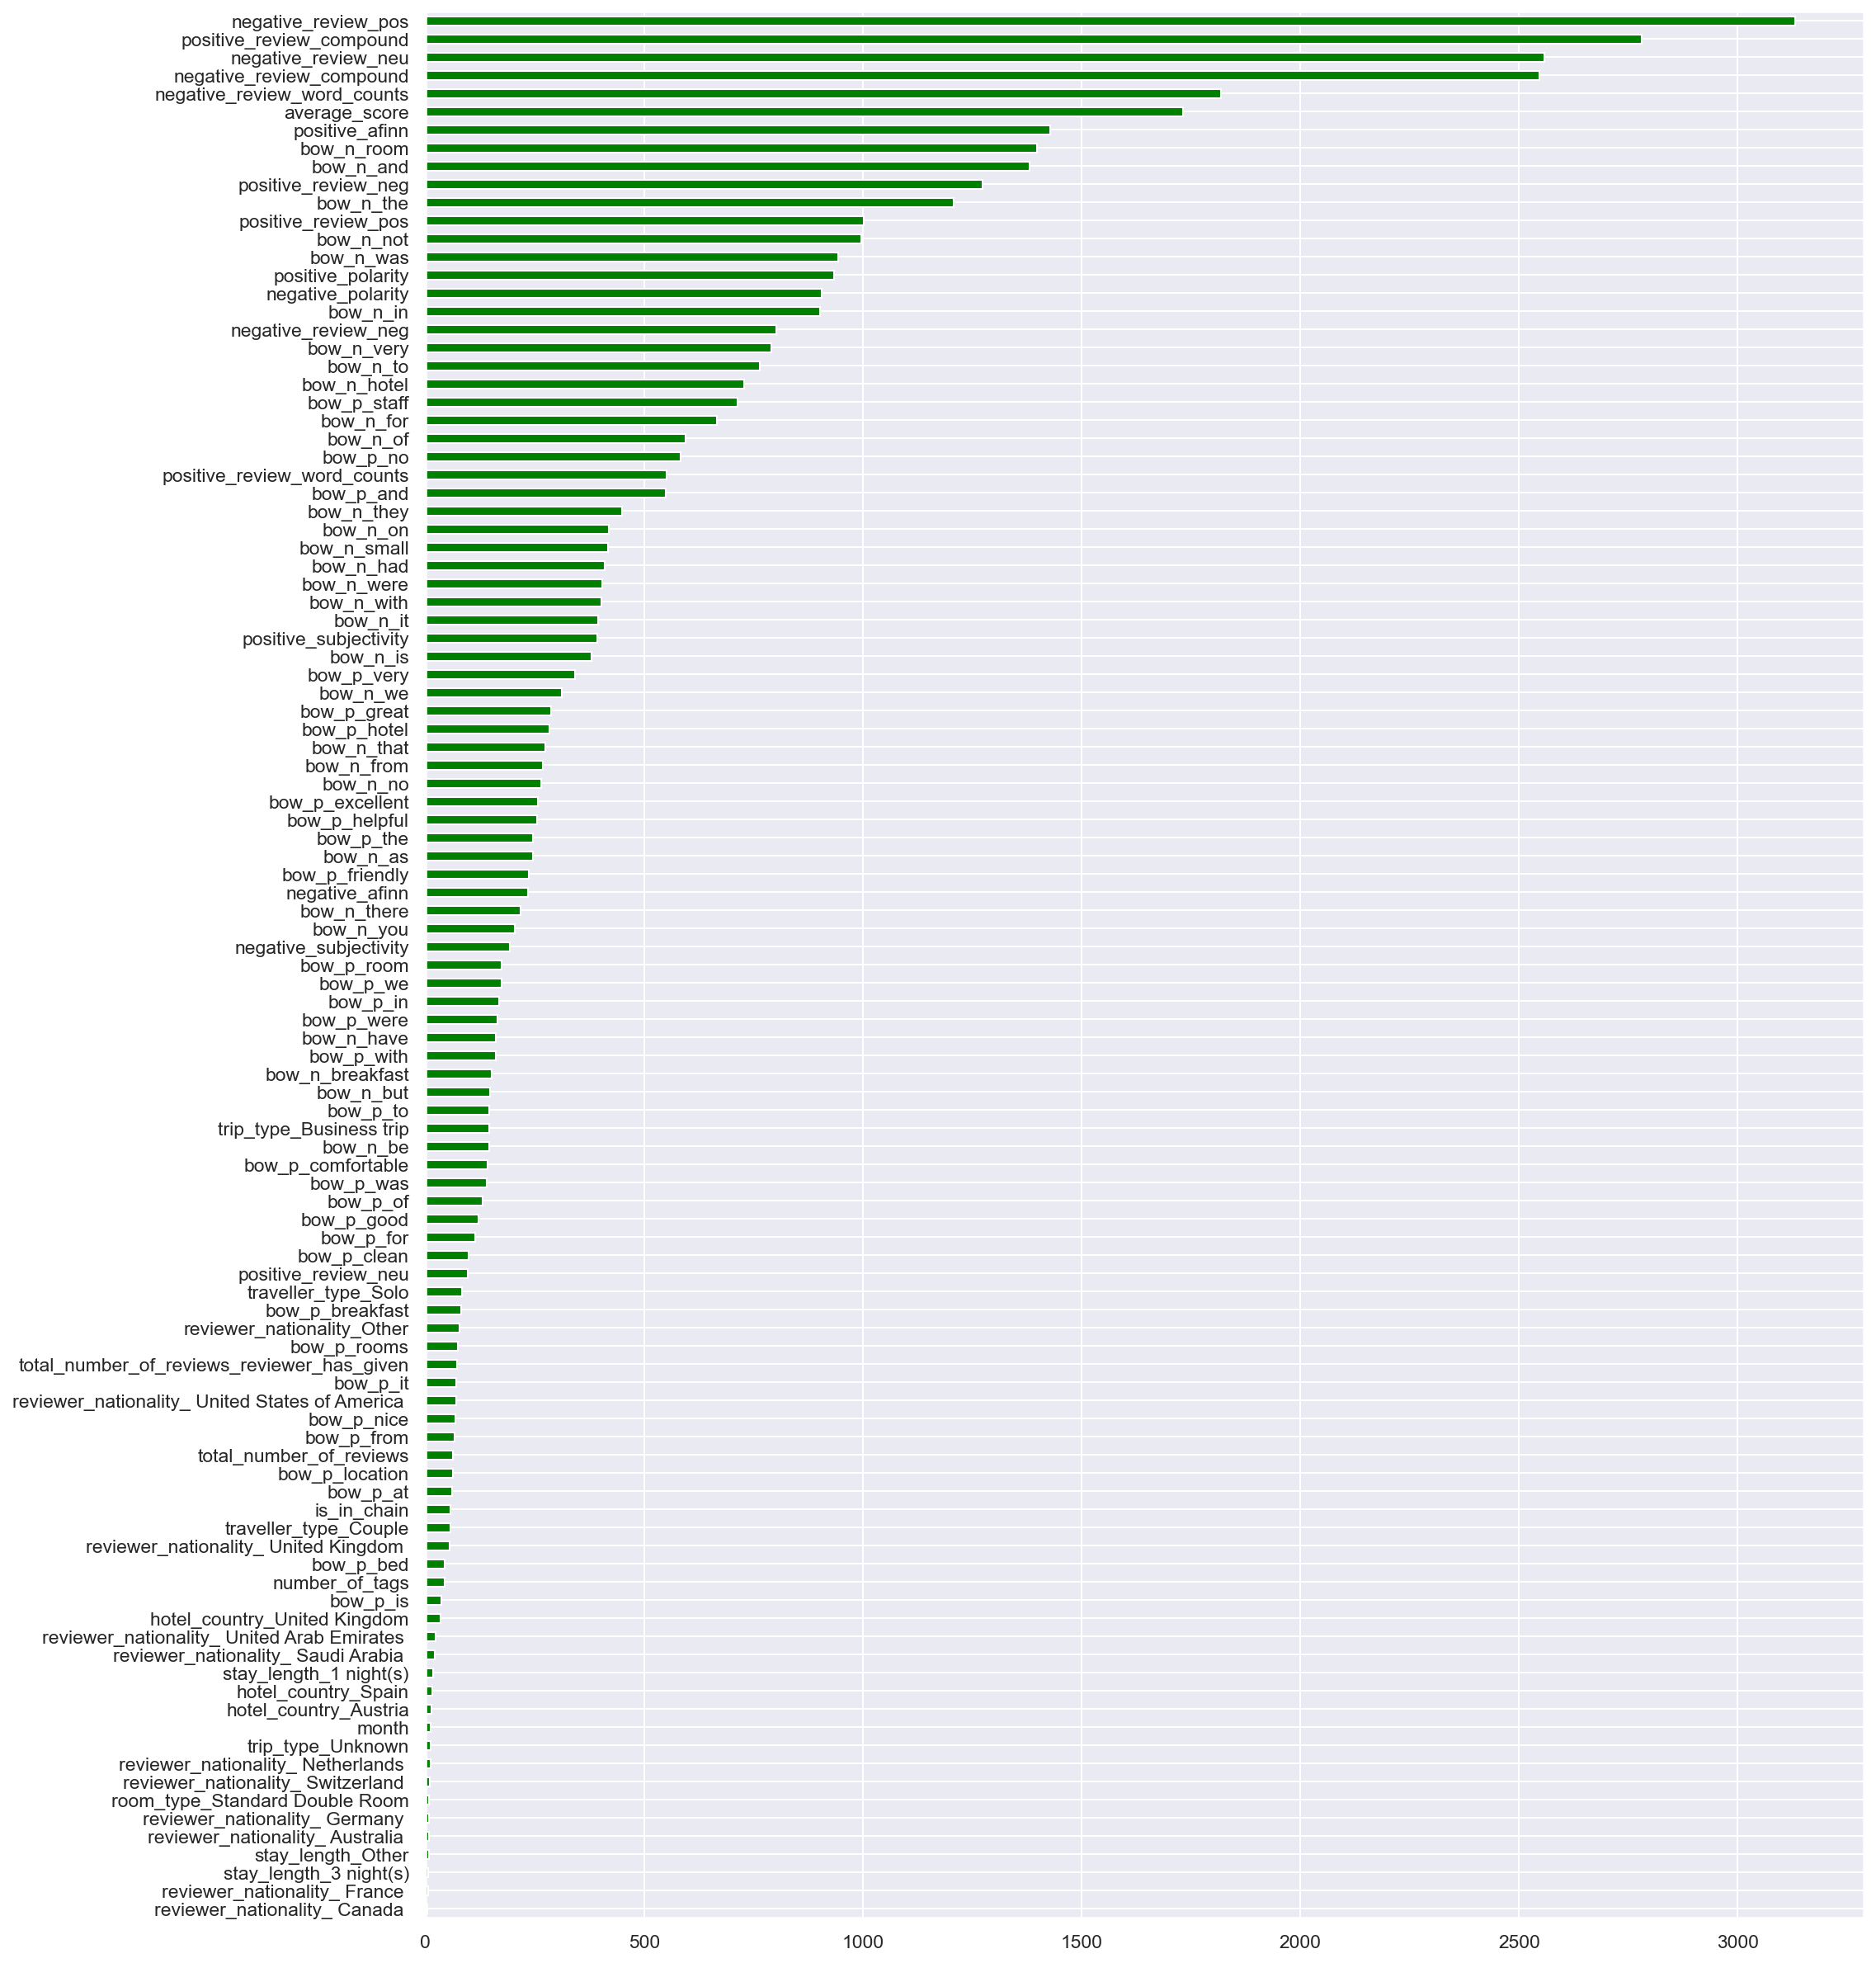

In [792]:
y = df.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = df.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

print(colored("Оценка значимости признаков дисперсионным анализом ANOVA:", 'green'))

In [793]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
#object_columns = [s for s in data.columns if df[s].dtypes == 'object']

#df.drop(object_columns, axis = 1, inplace=True)



# <p style="border:5px solid Navy;text-align:center;font-size:100%;">5.Построение модели</p>
<div class="alert alert-primary" role="alert">

In [794]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [795]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 106), (386803, 106), (386803, 105), (309442, 105), (77361, 105))

In [796]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [797]:
model = RandomForestRegressor(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1, 
    random_state=RANDOM_SEED)

In [798]:
%%time

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s


CPU times: total: 23min 38s
Wall time: 5min 20s


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


In [802]:
# зададим функцию для расчёта метрики
def mean_absolute_percentage_error(y_test, y_pred):
    """ Функция для расчёта метрики MAPE 
    
    Args:
        y_test: значения целевой переменной валидационной
                выборки
        y_pred: предсказанное значение целевой переменной
                на валидационной выборке
    Returns:
        float: значение метрики MAPE
    """
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# расчёт метрики
print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 8))


cprint('лучший показатель - 11.68587169', 'black', 'on_blue')



MAPE: 11.68587169
лучший показатель - 11.68587169


Выведем самые важные признаки для модели 

Признаки по уровню важности для модели RandomForestRegressor:


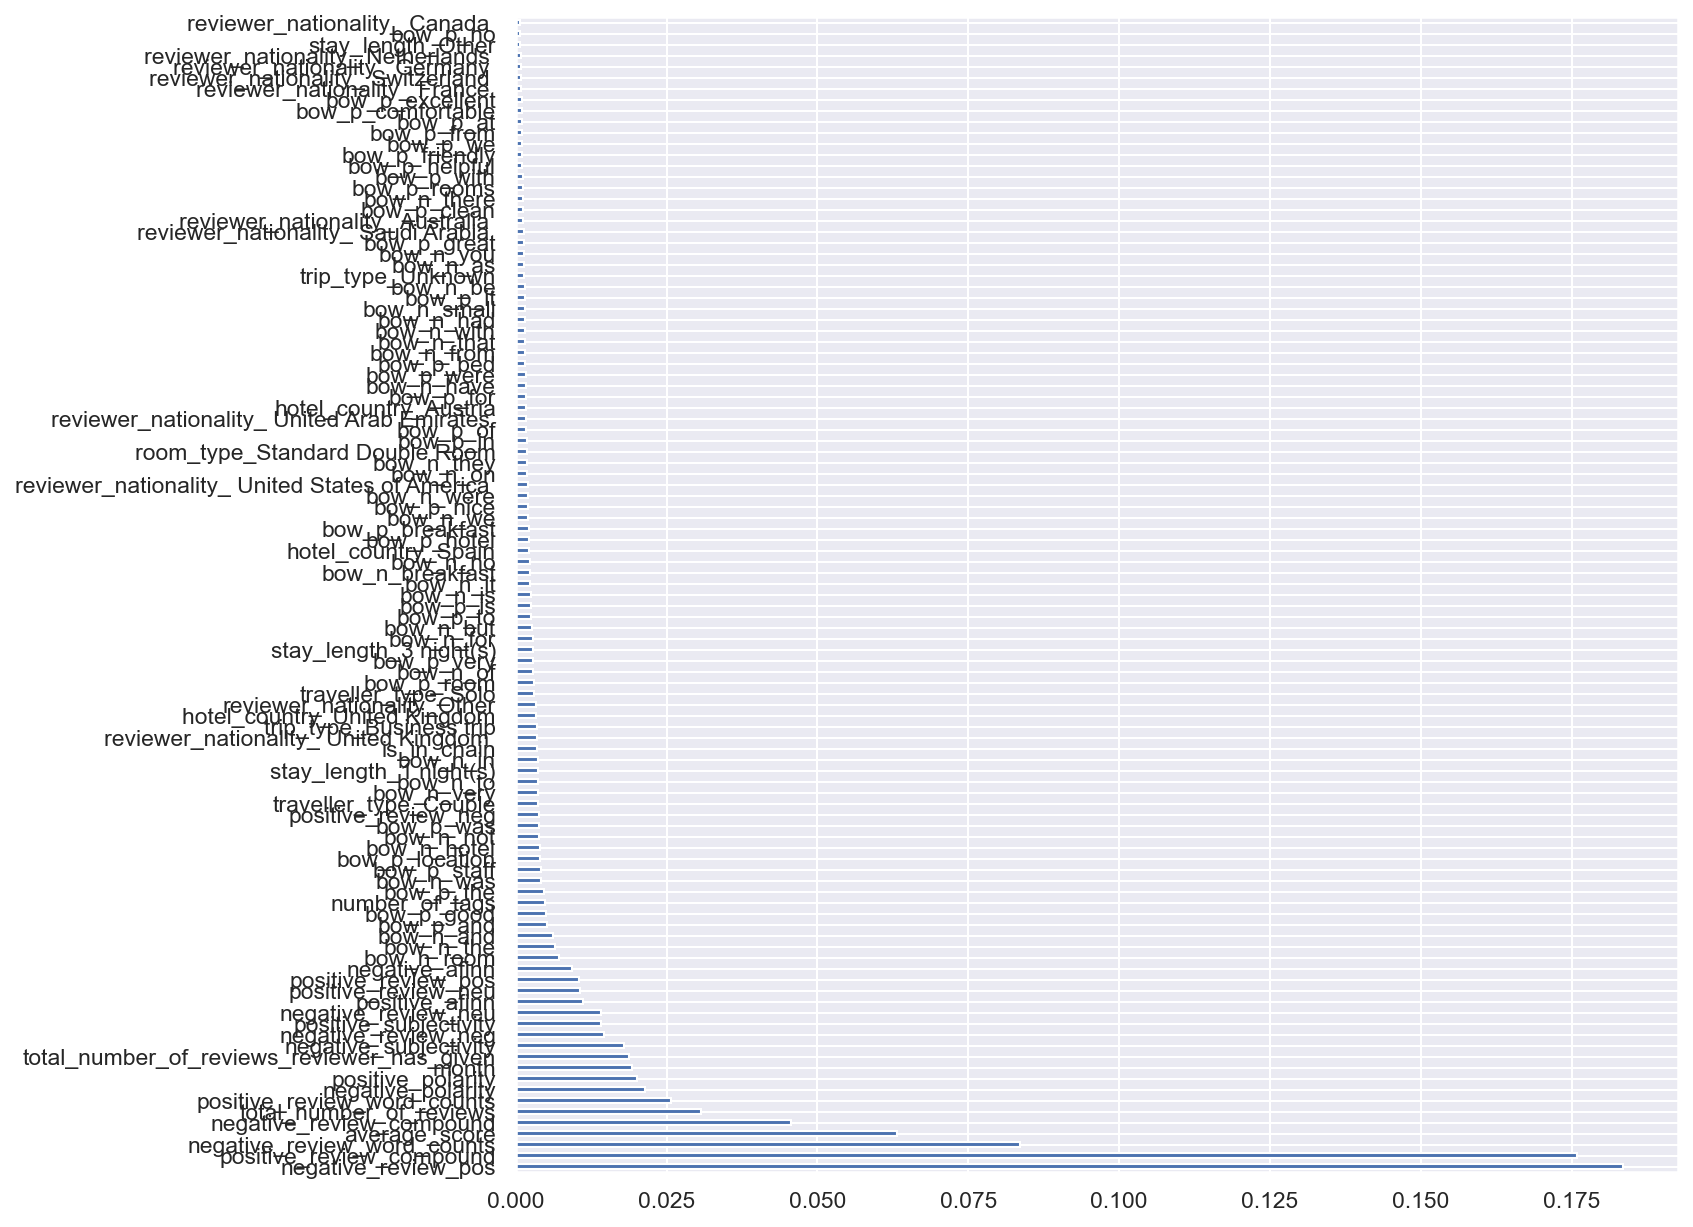

In [800]:

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(113).plot(kind='barh')
print('Признаки по уровню важности для модели RandomForestRegressor:')

# <p style="border:5px solid Navy;text-align:center;font-size:100%;">6.Заключение</p>
<div class="alert alert-primary" role="alert">

В заключении, хочу поблагодарить коллег из leaderboard на платформе kaggle. 

 